# **ORGANIZATION & NOTEBOOK INITIALIZATION (RUN EVERYTIME)** 

In [ ]:
######################################################################
### IMPORT PACKAGES & SETUP NOTEBOOK (RUN AT BEGINNING EVERY TIME) ###
######################################################################

project_name     = 'Wetlab_Data_Analysis'

### MANDATORY USER SPECIFICATIONS ###
github_repo_dir  = '/home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub' # Cloned GitHub repo directory path
obabel_path      = "/home/woodbuse/conda_envs/openbabel_env/bin/obabel"   # OpenBabel path

# 1.) subfolders to build in notebook directory
wrk_dirs_list = [
    'raw_wetlab_data', 'wetlab_data_plots' # optionally add more input subdirectories
]

###################################################### AUTO SETUP ######################################################
### STANDARD LIBRARY IMPORTS ###
import shlex, glob, json, math, os, random, copy, re, shutil, statistics, string, subprocess, sys
import textwrap, warnings, concurrent.futures, time, multiprocessing, itertools, operator
from pathlib import Path
from datetime import datetime

### DERIVED PATHS (CHANGE AT USER DISCRETION) ###
scripts_dir   = f'{github_repo_dir}/Scripts/'
software_dir  = f'{github_repo_dir}/Software/'
working_dir   = f'{github_repo_dir}/Manuscript_Data/'

for p in [working_dir, scripts_dir, software_dir]: 
    Path(p).mkdir(parents=True, exist_ok=True) # ensure base dirs exist so downstream cells never fail on missing paths

### 3RD PARTY IMPORTS ###
import numpy as np
import pandas as pd

### CUSTOM IMPORTS ###
if scripts_dir not in sys.path:
    sys.path.append(scripts_dir)
import General_NoteBook_Functions as functions

### SETUP SUBDIRECTORIES & CREATE VARIABLES ###
functions.setup_directories(working_dir, wrk_dirs_list, export_globals=True, globals_dict=globals())

### OPTIONALS ###
functions.set_pandas_display(all_on=True) # pandas display comfort defaults (toggle here if desired)
os.chdir(working_dir) # move into working dir for relative IO

### PRINTS ###
print(f"### PROJECT {project_name} NOTEBOOK SUCCESSFULLY INITIALIZED ON {datetime.now().strftime('%Y-%m-%d AT TIME %H:%M:%S')} ### ")
print(f"\nExample Variables & Paths:")
print(f"   working_dir   = {working_dir}")
if not Path(obabel_path).exists():
    print(f"⚠️  obabel not found at: {obabel_path} (you can proceed; update later)")

### PROJECT Wetlab_Data_Analysis NOTEBOOK SUCCESSFULLY INITIALIZED ON 2025-11-11 AT TIME 03:14:06 ### 

Example Variables & Paths:
   working_dir   = /home/woodbuse/publication/metallohydrolase/github/Computational_Design_of_Metallohydrolases_PrivateGitHub/Manuscript_Data/


# **I. FUNCTIONAL SCREENING DATA** 

text

## I.I. Design Campaign 1 Screening Results

### I.I.A. 96-Well Grid Plot of Individual Reaction Progress Curves

In [ ]:
# Load the CSV file
file_path1 = '/home/donghyo/projects/zinc_hydrolase/enzyme_design/20240405_design_campaign1/exp_data/plate_reader/240709_4mu_PA_ABCD.tsv'
data1 = pd.read_csv(file_path1, sep="\t")
data1_rename_dic = {"Time": "Time", "T° 365,445": "T° 365,445"}
for i, new_row in enumerate("AABBCCDD"):
    ori_row = "ABCDEFGH"[i]
    for col in range(1, 13):
        if i%2 == 0:
            data1_rename_dic[f"{ori_row}{col}"]= f"{new_row}{col}_wZN"
        else:
            data1_rename_dic[f"{ori_row}{col}"]= f"{new_row}{col}_woZN"
data1.rename(columns=data1_rename_dic, inplace=True)

# Load the CSV file
file_path2 = '/home/donghyo/projects/zinc_hydrolase/enzyme_design/20240405_design_campaign1/exp_data/plate_reader/240711_4mu_PA_EFGH.tsv'
data2 = pd.read_csv(file_path2, sep="\t")
data2_rename_dic = {"Time": "Time", "T° 365,445": "T° 365,445"}
for i, new_row in enumerate("EEFFGGHH"):
    ori_row = "ABCDEFGH"[i]
    for col in range(1, 13):
        if i%2 == 0:
            data2_rename_dic[f"{ori_row}{col}"]= f"{new_row}{col}_wZN"
        else:
            data2_rename_dic[f"{ori_row}{col}"]= f"{new_row}{col}_woZN"
############ DAMAGE CONTROL to fix my mistake in experiment ############
data2_rename_dic["E6"] = "G6_woZN"
data2_rename_dic["F6"] = "G6_wZN"
########################################################################

data1.rename(columns=data1_rename_dic, inplace=True)
data2.rename(columns=data2_rename_dic, inplace=True)

data = pd.merge(data1, data2, on='Time', how='inner')

# Convert 'Time' to a more usable format (assuming it's in hh:mm:ss)
data['Time'] = pd.to_timedelta(data['Time'])
data['Time'] = data['Time'].dt.total_seconds() / 60  # Convert time to minutes

# Standardization and Normalization
for letter in 'ABCDEFGH':
    for num in range(1, 13):
        #data[f'{letter}{num}_wZN'] = data[f'{letter}{num}_wZN'] - data[f'{blank_well}_wZN']
        data[f'{letter}{num}_wZN'] = data[f'{letter}{num}_wZN'] - np.min(data[f'{letter}{num}_wZN'].to_list())
        #data[f'{letter}{num}_woZN'] = data[f'{letter}{num}_woZN'] - data[f'{blank_well}_woZN']
        data[f'{letter}{num}_woZN'] = data[f'{letter}{num}_woZN'] - np.min(data[f'{letter}{num}_woZN'].to_list())


# Define pairs for plotting
pairs = []
for letter in 'ABCDEFGH':
    for num in range(1, 13):
        pairs.append((f'{letter}{num}_wZN', f'E5_wZN'))

# Find global min and max values for normalization
y_min = data[[col for pair in pairs for col in pair]].min().min()
y_max = data[[col for pair in pairs for col in pair]].max().max()

# Set up the plot grid
num_plots = len(pairs)
cols = 12
rows = (num_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.flatten()

# Custom titles and spine colors
custom_titles = {
    'B6': "PC1 (Don's)",
    'B7': "PC2 (Don's)",
    'D7': 'Blank (rxn buffer only)',
    'E5': 'Blank (rxn buffer only)',
    'F8': "Seth's C4",
    'G4': "PC1 (Don's)",
    'G6': "PC2 (Don's)",
    'H2': 'Blank (rxn buffer only)',
}
# Plot each pair
for i, (col1, col2) in enumerate(pairs):
    ax = axes[i]
    
    # Plot the data
    ax.plot(data['Time'], data[col1], color='red')
    ax.plot(data['Time'], data[col2], color='black')
    
    # Set axis labels and title
    #ax.set_xlabel('Time (minutes)')
    #ax.set_ylabel('Fluorescence Units')
    
    ax.set_ylim(y_min, y_max)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

cute_pics_dir = "./pics/"
    
plt.tight_layout()
plt.savefig(f'{cute_pics_dir}240709_4mu_PA_screening.svg') 
plt.show()


### I.I.B. Combined Plot of Reaction Progress Curves

In [ ]:
# Load the CSV file
file_path1 = '/home/donghyo/projects/zinc_hydrolase/enzyme_design/20240405_design_campaign1/exp_data/plate_reader/240709_4mu_PA_ABCD.tsv'
data1 = pd.read_csv(file_path1, sep="\t")
data1_rename_dic = {"Time": "Time", "T° 365,445": "T° 365,445"}
for i, new_row in enumerate("AABBCCDD"):
    ori_row = "ABCDEFGH"[i]
    for col in range(1, 13):
        if i%2 == 0:
            data1_rename_dic[f"{ori_row}{col}"]= f"{new_row}{col}_wZN"
        else:
            data1_rename_dic[f"{ori_row}{col}"]= f"{new_row}{col}_woZN"
data1.rename(columns=data1_rename_dic, inplace=True)

# Load the CSV file
file_path2 = '/home/donghyo/projects/zinc_hydrolase/enzyme_design/20240405_design_campaign1/exp_data/plate_reader/240711_4mu_PA_EFGH.tsv'
data2 = pd.read_csv(file_path2, sep="\t")
data2_rename_dic = {"Time": "Time", "T° 365,445": "T° 365,445"}
for i, new_row in enumerate("EEFFGGHH"):
    ori_row = "ABCDEFGH"[i]
    for col in range(1, 13):
        if i%2 == 0:
            data2_rename_dic[f"{ori_row}{col}"]= f"{new_row}{col}_wZN"
        else:
            data2_rename_dic[f"{ori_row}{col}"]= f"{new_row}{col}_woZN"
############ DAMAGE CONTROL to fix my mistake in experiment ############
data2_rename_dic["E6"] = "G6_woZN"
data2_rename_dic["F6"] = "G6_wZN"
########################################################################

data1.rename(columns=data1_rename_dic, inplace=True)
data2.rename(columns=data2_rename_dic, inplace=True)

data = pd.merge(data1, data2, on='Time', how='inner')

# Convert 'Time' to a more usable format (assuming it's in hh:mm:ss)
data['Time'] = pd.to_timedelta(data['Time'])
data['Time'] = data['Time'].dt.total_seconds() / 60  # Convert time to minutes

# Standardization and Normalization
for letter in 'ABCDEFGH':
    for num in range(1, 13):
        data[f'{letter}{num}_wZN'] = data[f'{letter}{num}_wZN'] - np.min(data[f'{letter}{num}_wZN'].to_list())
        data[f'{letter}{num}_woZN'] = data[f'{letter}{num}_woZN'] - np.min(data[f'{letter}{num}_woZN'].to_list())


# Define pairs for plotting
pairs = []
for letter in 'ABCDEFGH':
    for num in range(1, 13):
        pairs.append((f'{letter}{num}_wZN', f'E5_wZN'))

# Find global min and max values for normalization
y_min = data[[col for pair in pairs for col in pair]].min().min()
y_max = data[[col for pair in pairs for col in pair]].max().max()

# Set up the plot grid
plt.figure(figsize=(6, 5.5))

# Custom titles and spine colors
custom_titles = {
    'B6': "PC1 (Don's)",
    'B7': "PC2 (Don's)",
    'D7': 'Blank (rxn buffer only)',
    'E5': 'Blank (rxn buffer only)', # We chose this one
    'F8': "Seth's C4",
    'G4': "PC1 (Don's)",
    'G6': "PC2 (Don's)",
    'H2': 'Blank (rxn buffer only)',
}

# Plot all the wells excluding positive controls and one blank
for col in range(1,13):
    for row in "ABCDEFGH":
        well = f"{row}{col}"
        # Exclude Positive Controls (Don's and Seth's) and Useless Blank
        if well in ["B6", "B7", "D7", "F8", "G4", "G6", "H2"]: continue

        # Big Hits
        if well in ["A1", "A8", "B9", "C4", "F7"]: 
            plt.plot(data['Time'], data[well+"_wZN"], label=well, color='red')
        # Intermediate Hits
        elif well in ["A2", "A5", "D9", "E3", "E8", "F2", "F3", "G7", "H5"]:
            plt.plot(data['Time'], data[well+"_wZN"], label=well, color='pink')
        # Non-Hit example
        elif well in ["H7", "H8"]:
            plt.plot(data['Time'], data[well+"_wZN"], label=well, color='black')
        # Blank
        elif not well in ["A1", "A8", "B9", "C4", "F7", "E5"]:
            plt.plot(data['Time'], data[well+"_wZN"], label=well, color='gray')
        # Small or Non hits
        elif well == "E5":
            plt.plot(data['Time'], data[well+"_wZN"], label=well, color='black', linestyle='dashed')
    
    # Set axis labels and title
    plt.xlabel('Time (minutes)')
    plt.ylabel('Fluorescence Units')
    
plt.tight_layout()
plt.savefig("/home/donghyo/projects/zinc_hydrolase/enzyme_design/20240405_design_campaign1/cute_pics/241006_donghyo_4muPA_integrated_screening_results.eps", format="eps")
plt.show()


## I.II. Design Campaign 2 Screening Results

MOVE FUNCTION

In [ ]:
def parse_excels(excel_file, active_wells, start_row=30, skipfooter=35):
    # Create an empty list to store active wells
    active_wells = []

    num_samples = len(active_wells)

    # file name
    bn = os.path.basename(excel_file).replace('.xlsx','')
    
    # Read the table until there is no more data, skipping the first row
    df = pd.read_excel(excel_file, header=start_row, skipfooter=skipfooter, engine='openpyxl')

    # Drop rows and columns containing NaN values
    df = df.dropna(axis=1, how='all').dropna(axis=0, how='all')

    # Reset the index
    df.reset_index(drop=True, inplace=True)
    # df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.time
    try: df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce').dt.time
    except KeyError:
        print (df.head(3))
        raise ValueError("Please vary start_row. Time is not observed in the column.")

    # Convert the time column to mintues
    df['Time'] = df['Time'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)
    df['Time'] = df['Time'] / 60
    df_final = df.dropna(axis=1, how='all').dropna(axis=0, how='all')

    # Display the resulting DataFrame
    df_final.head()
    data = df_final

    return data

def trim_time_end(df, time_cutoff_hours = 6):
    df = df[df["Time"] < time_cutoff_hours].copy()
    return df
    
def trim_time_start(df, time_cutoff_hours = 1):
    df = df[df["Time"] > time_cutoff_hours].copy()
    df.loc[:, "Time"] -= df["Time"].iloc[0]
    return df

def normalize_to_first_row(df, active_wells):
    for well in active_wells:
        df[well] -= df[well].iloc[0]
    return df

def normalize_to_min(df, active_wells):
    for well in active_wells:
        df[well] -= min(df[well])
    return df
    
def draw_progression_curve_v0(excel_file, rows, columns, hit_definition_num, blank, time_start, time_end, label=True, start_row=30, ignore=None, reverse=True, save=None): 
    # Active well define
    active_wells = []
    for row in rows:
        for column in columns:
            if ignore:
                if f"{row}{column}" in ignore:
                    continue
            active_wells.append(f"{row}{column}")
    
    # Data preprocessing
    df = parse_excels(excel_file, active_wells, start_row=start_row)
    df = trim_time_end(df, time_cutoff_hours = time_end)
    df = trim_time_start(df, time_cutoff_hours = time_start)
    #df = normalize_to_first_row(df, active_wells)
    
    # Hit define
    if reverse:
        possible_hits = df.iloc[-1].nsmallest(hit_definition_num).index
    else:
        possible_hits = df.iloc[-1].nlargest(hit_definition_num).index
    print (f"Hits are: {', '.join(possible_hits)}")
    
    # Plotting
    fig, ax = plt.subplots(figsize=(4, 3.5))
    for well in active_wells:
        if well in blank:
            ax.plot(df['Time'], df[well], label=well, color='black', linestyle='dashed')
        elif well in possible_hits:
            ax.plot(df['Time'], df[well], label=well, color='red')
            x_pos = df['Time'].iloc[-1]
            y_pos = df[well].iloc[-1]
            if label:
                ax.text(x_pos+(x_pos*0.0), y_pos, well, color='red', ha='left', va='bottom', fontsize=8)
        else:
            ax.plot(df['Time'], df[well], label=well, color='lightgray', alpha=0.2)
        
    # Set axis labels and title
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('RFU')
    previous_xlim = ax.get_xlim()
    ax.set_xlim(previous_xlim[0], (previous_xlim[1]*1.01))
        
    plt.tight_layout()
    if save:
        plt.savefig(save, format="eps")
    plt.show()


def draw_progression_curve_seperate_v0(excel_file, rows, columns, bg, time_start, time_end, start_row=48, reverse=False, save=None):
    # Active well define
    active_wells, pairs = [], []
    for row in rows:
        for column in columns:
            active_wells.append(f"{row}{column}")
            pairs.append((f'{row}{column}', bg))
    
    # Data preprocessing
    df = parse_excels(excel_file, active_wells, start_row=start_row)
    df = trim_time_end(df, time_cutoff_hours = time_end)
    df = trim_time_start(df, time_cutoff_hours = time_start)
    
    # Find global min and max values for normalization
    y_min = df[[col for pair in pairs for col in pair]].min().min()
    y_max = df[[col for pair in pairs for col in pair]].max().max()
    
    # Set up the plot grid
    num_plots = len(pairs)
    cols = 12
    rows = (num_plots + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = axes.flatten()

    # Plot each pair
    for i, (col1, col2) in enumerate(pairs):
        ax = axes[i]
        
        # Plot the data
        ax.plot(df['Time'], df[col1], color='red')
        ax.plot(df['Time'], df[col2], color='black')
        
        ax.set_ylim(y_min, y_max)
    
    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    cute_pics_dir = "./pics/"
        
    plt.tight_layout()
    if save:
        plt.savefig(save) 
    plt.show()

### I.II.A. 96-Well Grid Plot of Individual Reaction Progress Curves

In [ ]:
### Input
excel_file = os.path.join("/home/donghyo/250307_singleZn_order1_cowboy_elutantScreen_100uM_4MUPA_and_100uM_suppZn_25C.xlsx")
eps_out = "/home/donghyo/projects/double_zinc_esterase/241204_double_zinc_esterase/pics/250307_screening_result_100uM_4MUPA_100uM_suppZn_25C_separated.eps"
rows, columns = list("ABCDEFGH"), list(range(1,13))
bg = "A5"
time_start = 0
time_end = 60
# Scaffold1: ["F2", "F8", "F11", "H1", "H10"]
# Scaffold2: ["B5", "B10", "D9", "F12", "H6"]
# Scaffold3: ["C5"]

draw_progression_curve_seperate_v0(excel_file, rows, columns, bg, time_start, time_end, start_row=48, reverse=False, save=eps_out)

### I.II.B. Combined Plot of Reaction Progress Curves

In [ ]:
### Input
#excel_file = os.path.join(net_exp_woodbuse, "neo2_platereader/zinc_hydrolase_ULTRAop/single_zinc_esterase/", "250307_singleZn_order1_cowboy_elutantScreen_100uM_4MUPA_and_100uM_suppZn_25C.xlsb")
excel_file = os.path.join("/home/donghyo/250307_singleZn_order1_cowboy_elutantScreen_100uM_4MUPA_and_100uM_suppZn_25C.xlsx")
eps_out = "/home/donghyo/projects/double_zinc_esterase/241204_double_zinc_esterase/pics/250307_screening_result_100uM_4MUPA_100uM_suppZn_25C.eps"
rows, columns = list("ABCDEFGH"), list(range(1,13))
hit_definition_num = 13
blank = []
time_start = 0
time_end = 60
ignore = ["A5", "A8", "B6", "E8", "F4", "G2", "G7", "G10", "G11", "H7", "H9"]
# Scaffold1: ["F2", "F8", "F11", "H1", "H10"]
# Scaffold2: ["B5", "B10", "D9", "F12", "H6"]
# Scaffold3: ["C5"]

draw_progression_curve_v0(excel_file, rows, columns, hit_definition_num, blank, time_start, time_end, label=False, start_row=48, ignore=ignore, reverse=False, save=eps_out)

## I.III. ZETA_1 (A1) Variant Screening Results

### I.III.A. Combined Plot of Reaction Progress Curves

In [ ]:
# Load the CSV file
file_path1 = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase/240826_zn_hydrolase_donghyo_knockouts_AND_variants_200uM_zn_25uM_PA_AND_100uM_PA.xlsx'
data1 = pd.read_excel(file_path1, header=48, skipfooter=36)
data = data1.copy()
data = data.dropna(axis=1, how='all').dropna(axis=0, how='all')
data.reset_index(drop=True, inplace=True)

# Convert 'Time' to a more usable format (assuming it's in hh:mm:ss)
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S', errors='coerce')

# Calculate total seconds and convert to minutes
data['Time'] = (data['Time'] - pd.Timestamp('1900-01-01 00:00:00')).dt.total_seconds() / 60

# Set up the plot grid
plt.figure(figsize=(6, 5.5))

active_wells = ["A1", "E11", "E12", "F1", "F2", "F3", "F4", "F5", "F6", "F7"]


# Zero-ing
for well in active_wells:
    data[well] = data[well] - data[well].to_list()[0]

# Plot all the wells
for i, well in enumerate(active_wells):
    if i == 0:
        plt.plot(data['Time'], data[well], label=well)
    elif i < 8:
        plt.plot(data['Time'], data[well], label=f"A1_var{i}")
    elif i == 8:
        plt.plot(data['Time'], data[well], label=f"A1_par")
    else:
        plt.plot(data['Time'], data[well], label="Blank", linestyle='dashed', color='black')
    
    # Set axis labels and title
    plt.xlabel('Time (minutes)')
    xlim = plt.xlim()
    plt.xlim(xlim[0], 16)
    plt.ylabel('Fluorescence Units')
    
plt.tight_layout()
plt.legend()
plt.savefig("/home/donghyo/projects/zinc_hydrolase/enzyme_design/20240405_design_campaign1/cute_pics/240826_A1_variations_progression_curves.eps", format="eps")
plt.show()


## I.IV. ZETA_1 (A1) Mutant (Knockout) Screening Results

### I.IV.A. Combined Plot of Reaction Progress Curves

findfont: Font family ['Arial Unicode MS'] not found. Falling back to DejaVu Sans.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


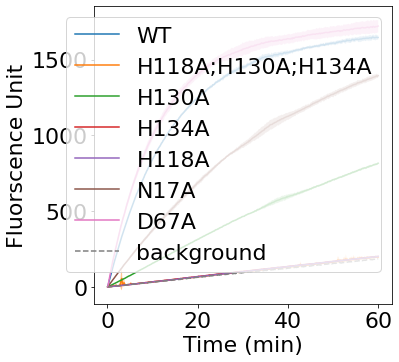

In [ ]:
# excel file output from neo2
excel_file = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase/paper_data/240906_a1_plus_6mutants_AND_standard_curve___1pt8_uM_4muPA_100nM_enz_25C_1hr.xlsx'

# Specify row and column ranges
row_column_ranges = {
    'A': (1, 7),
    'B': (1, 7),
    'C': (1, 7),
    'D': (1, 7),
    'E': (1, 7),
    'F': (1, 7),
    'G': (1, 7),
}

# Specify replicates
replicate_dic = {
    1: [2, 3]
}

# Specify background
background_col = 4

# Create an empty list to store active wells
active_wells = []

# Iterate through rows/columns, append to active wells
for row, (start_col, end_col) in row_column_ranges.items():
    for col in range(start_col, end_col + 1):
        active_wells.append(f"{row}{col}")

# Specify standarization slope
slope = np.average([6.857301209337525e-10, 7.101340604738747e-10, 7.18193078001004e-10])

# Load data
screening_data = kinetics.parse_kinetics(excel_file, active_wells, start_row=48)
"""
# Standardize
for well in active_wells:
    fu = screening_data[well].values
    product_concentration = fu * slope * 1000000
    screening_data[well] = product_concentration
"""
# Zero-ing        
for well in active_wells:
    screening_data[well] = screening_data[well] - np.min(screening_data[well])

"""
# Normalize
for well in active_wells:
    row = well[0]
    screening_data[well] = np.array(screening_data[well]) - np.array(screening_data[f'{row}{background_col}'])
"""
# Convernting time
screening_data["Time"] = screening_data["Time"]/60

plt.figure(figsize=(6, 5.5))

for representive_col in replicate_dic:
    replicates = [representive_col]
    replicates.extend(replicate_dic[representive_col])
    
    for row, name in zip(["A", "B", "C", "D", "E", "F", "G"], ["WT", "H118A;H130A;H134A", "H130A", "H134A", "H118A", "N17A", "D67A"]):
        
        replicates_well = [f"{row}{col}" for col in replicates]
        avg_product_concentration = np.array(screening_data[replicates_well].mean(axis=1).tolist())
        std_product_concentration = np.array(screening_data[replicates_well].std(axis=1).tolist())
        
        plt.plot(screening_data["Time"].values, avg_product_concentration, label=name)
        plt.fill_between(screening_data["Time"].values, 
                             avg_product_concentration - std_product_concentration,
                             avg_product_concentration + std_product_concentration,
                             alpha = 0.45)
        
    plt.plot(screening_data["Time"].values, screening_data[f"{row}{background_col}"], linestyle='dashed', label="background")
    
    #plt.ylabel("[4MU] (uM)")
    plt.ylabel("Fluorscence Unit")
    plt.xlabel("Time (min)")

plt.legend()
plt.tight_layout()
plt.savefig("/home/donghyo/projects/zinc_hydrolase/enzyme_design/20240405_design_campaign1/cute_pics/" + 
            "A1_KO_experiment_progression_curves.eps", 
            format='eps')
plt.show()

# **II. KINETIC MEASUREMENT DATA** 

## II.I. Standard Curves & Background Reaction Rate (*k*<sub>uncat</sub>)



### II.I.A. Standard Curves for X

### II.I.B. Background Reaction Rate for 4MU-PA Hydrolysis (*k*<sub>uncat</sub>)

In [ ]:
### Input/Output File/Directiory ###
excel_file = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase_ULTRAop/single_zinc_esterase/250415_BLANK_kuncat_experiment__phenylacetate_subst_25C_1hour_no_zn_144uMsubstLadder.xlsx'
pics_dir = './pics/'
os.makedirs(pics_dir, exist_ok=True)

### Input Parameter ###
slope = np.average([9.296712951159367e-10, 9.447803716354774e-10, 9.40363467934009e-10]) # NEWEST ONE (250401)

enz_conc = 1e6 #
rows, cols = list("ABCDEFGH"), [1,2,3,4]
replicate_dic = {1: [2, 3]}
bg_col = 4
sub_concs = np.array([72, 36, 18, 9, 4.5, 2.3, 1.1])              #[144, 72, 36, 18, 9, 4.5, 2.25, 1.125]
col_range_to_analyze = (2, 8)                                     # From 2nd to 8th columns
start_time = 30
end_time = 500
substrate_name = '4MU-PA'

### Parameter Preprocessing ###
transpose_dic = make_transpose_dic(rows, cols)
rename_dic = make_rename_dic(transpose_dic, rows, cols)
represent_row = "A"
replicate_rows = ["ABCDEFGHIJKL"[cols.index(rep)] for rep in list(replicate_dic.values())[0]]
bg_row = "ABCDEFGHIJKL"[cols.index(bg_col)]
row_column_ranges = {represent_row: col_range_to_analyze}
active_wells = make_active_wells(row_column_ranges)

### Data Parsing/Plotting ###
bn = os.path.basename(f'{excel_file}').replace('.xlsx','')
kinetic_data = parse_kinetics(excel_file, active_wells, start_row=48)
kinetic_data.rename(columns=rename_dic, inplace=True)
v0_enz = mm_kinetics(kinetic_data, bn, rows, cols, active_wells, bg_row, enz_conc, sub_concs, substrate_name, pics_dir, replicate_rows, fit_type='straight_line', slope=slope,
            cutoff_start_time=start_time, cutoff_end_time=end_time, plate_type='full', y_ax_mm_intv=0.1, x_ax_mm_intv=50, legend_label=f'[{substrate_name}], μM', norm_zero=True, silent=True, ylabel="vx10$^{-3}$ (s$^{-1}$)")

### Measuring kuncat ###
v0_list, sub_conc_list = [], []
for i, sub_conc in enumerate(sub_concs):
    v0_list.append(v0_enz[i]*1e-6*enz_conc)
    sub_conc_list.append(sub_conc*1e-6)

# Perform linear fit using NumPy's polyfit
coefficients = np.polyfit(sub_conc_list, v0_list, 1)  # 1 for linear fit
print (f"kuncat: {coefficients[0]}")
print (f"coefficients: {coefficients}")

## II.II. Michaelis-Menten Kinetics for Top 5 Design Campaign 1 Hits (5 Unique RFdiffusion2 Scaffolds)



### II.II.A. 241008 ZETA_1 (A1) Kinetics ([E]<sub>0</sub> = 100nM; [Zn(II)] = 4μM; Temp = 25C)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


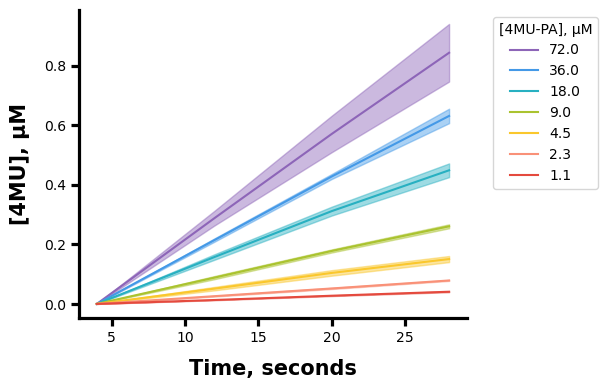

/home/donghyo/projects/ultra_optimized_single_zinc_esterase/design_campaign_ultra1_241122/kinetics_v2.py:418: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticklabels)


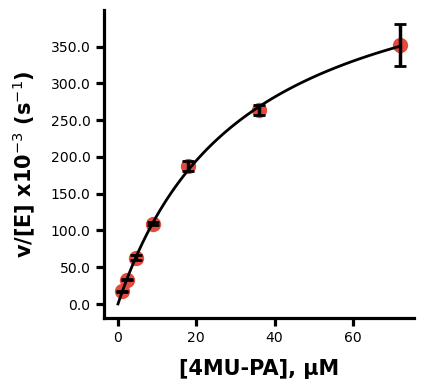

kcat:0.505797±0.030438s⁻¹
Km:31.90±4.14μM
kcat/Km: 15858.05 ± 2268.30 M⁻¹ s⁻¹

[SUBST] = 72.0uM, v0 = 3.5196917579962305e-07
[SUBST] = 36.0uM, v0 = 2.6365435094886797e-07
[SUBST] = 18.0uM, v0 = 1.8773253162165834e-07
[SUBST] = 9.0uM, v0 = 1.0903499181441171e-07
[SUBST] = 4.5uM, v0 = 6.313786725717997e-08
[SUBST] = 2.3uM, v0 = 3.280041525001486e-08
[SUBST] = 1.1uM, v0 = 1.7162553390651396e-08


In [ ]:
### Input/Output File/Directiory ###
excel_file = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase/paper_data/241008_A1_FINAL_kinetics_100nM___phenylacetate_subst_25C_5min_40x_zn_144uMsubstLadder.xlsx'
pics_dir = './pics/'
os.makedirs(pics_dir, exist_ok=True)

### Input Parameter ###
#slope = np.average([9.710399908638067e-10, 9.561887458844373e-10, 9.695313428289856e-10]) # NEW ONE - After removing the last two points
slope = np.average([9.296712951159367e-10, 9.447803716354774e-10, 9.40363467934009e-10]) # NEWEST ONE (250401)

enz_conc = 0.1
rows, cols = list("ABCDEFGH"), [1,2,3,4]
replicate_dic = {1: [2, 3]}
bg_col = 4
sub_concs = np.array([72, 36, 18, 9, 4.5, 2.3, 1.1])              #[144, 72, 36, 18, 9, 4.5, 2.25, 1.125]
col_range_to_analyze = (2, 8)                                     # From 2nd to 8th columns
start_time = 0
end_time = 30
substrate_name = '4MU-PA'

### Parameter Preprocessing ###
transpose_dic = make_transpose_dic(rows, cols)
rename_dic = make_rename_dic(transpose_dic, rows, cols)
represent_row = "A"
replicate_rows = ["ABCDEFGHIJKL"[cols.index(rep)] for rep in list(replicate_dic.values())[0]]
bg_row = "ABCDEFGHIJKL"[cols.index(bg_col)]
row_column_ranges = {represent_row: col_range_to_analyze}
active_wells = make_active_wells(row_column_ranges)

### Data Parsing/Plotting ###
bn = os.path.basename(f'{excel_file}').replace('.xlsx','')
kinetic_data = parse_kinetics(excel_file, active_wells, start_row=48)
kinetic_data.rename(columns=rename_dic, inplace=True)
v0_enz = mm_kinetics(kinetic_data, bn, rows, cols, active_wells, bg_row, enz_conc, sub_concs, substrate_name, pics_dir, replicate_rows, fit_type='straight_line', slope=slope,
            cutoff_start_time=start_time, cutoff_end_time=end_time, plate_type='full', y_ax_mm_intv=0.1, x_ax_mm_intv=50, legend_label=f'[{substrate_name}], μM', norm_zero=True)


### II.II.B. 240830 A8 Kinetics ([E]<sub>0</sub> = 2μM; [Zn(II)] = 20μM; Temp = 25C)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


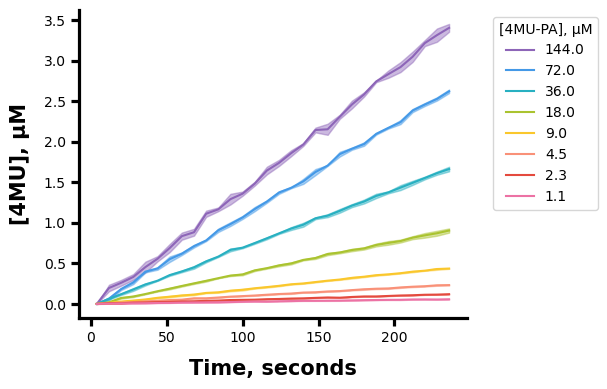

/home/donghyo/projects/ultra_optimized_single_zinc_esterase/design_campaign_ultra1_241122/kinetics_v2.py:418: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticklabels)


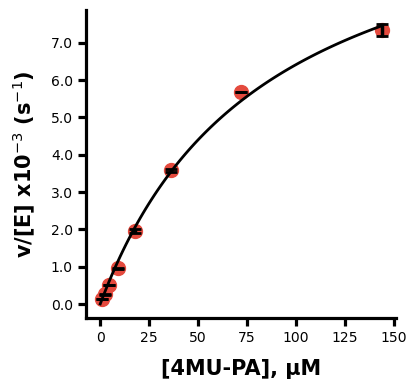

kcat:0.011844±0.000378s⁻¹
Km:84.61±5.31μM
kcat/Km: 139.99 ± 9.86 M⁻¹ s⁻¹

[SUBST] = 144.0uM, v0 = 7.340684584302558e-09
[SUBST] = 72.0uM, v0 = 5.678805169789556e-09
[SUBST] = 36.0uM, v0 = 3.5785133405513774e-09
[SUBST] = 18.0uM, v0 = 1.9586856847091307e-09
[SUBST] = 9.0uM, v0 = 9.589149068472353e-10
[SUBST] = 4.5uM, v0 = 5.080957012753525e-10
[SUBST] = 2.3uM, v0 = 2.5251059141429323e-10
[SUBST] = 1.1uM, v0 = 1.256943156793775e-10


In [ ]:
### Input/Output File/Directiory ###
excel_file = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase/paper_data/240830_A8_OFFICIAL_kinetics_2uM___phenylacetate_subst_25C_4min_10x_zn.xlsx'
pics_dir = './pics/'
os.makedirs(pics_dir, exist_ok=True)

### Input Parameter ###
#slope = np.average([9.710399908638067e-10, 9.561887458844373e-10, 9.695313428289856e-10]) # NEW ONE - After removing the last two points
slope = np.average([9.296712951159367e-10, 9.447803716354774e-10, 9.40363467934009e-10]) # NEWEST ONE (250401)

enz_conc = 2.0
rows, cols = list("ABCDEFGH"), [1,2,3,4]
replicate_dic = {1: [2, 3]}
bg_col = 4
sub_concs = np.array([144, 72, 36, 18, 9, 4.5, 2.3, 1.1])              #[144, 72, 36, 18, 9, 4.5, 2.25, 1.125]
col_range_to_analyze = (1, 8)                                     # From 1st to 8th columns
start_time = 0
end_time = 240
substrate_name = '4MU-PA'

### Parameter Preprocessing ###
transpose_dic = make_transpose_dic(rows, cols)
rename_dic = make_rename_dic(transpose_dic, rows, cols)
represent_row = "A"
replicate_rows = ["ABCDEFGHIJKL"[cols.index(rep)] for rep in list(replicate_dic.values())[0]]
bg_row = "ABCDEFGHIJKL"[cols.index(bg_col)]
row_column_ranges = {represent_row: col_range_to_analyze}
active_wells = make_active_wells(row_column_ranges)

### Data Parsing/Plotting ###
bn = os.path.basename(f'{excel_file}').replace('.xlsx','')
kinetic_data = parse_kinetics(excel_file, active_wells, start_row=48)
kinetic_data.rename(columns=rename_dic, inplace=True)
v0_enz = mm_kinetics(kinetic_data, bn, rows, cols, active_wells, bg_row, enz_conc, sub_concs, substrate_name, pics_dir, replicate_rows, fit_type='straight_line', slope=slope,
            cutoff_start_time=start_time, cutoff_end_time=end_time, plate_type='full', y_ax_mm_intv=0.1, x_ax_mm_intv=50, legend_label=f'[{substrate_name}], μM', norm_zero=True)


### II.II.C. 240830 B9 Kinetics ([E]<sub>0</sub> = 2μM; [Zn(II)] = 20μM; Temp = 25C)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


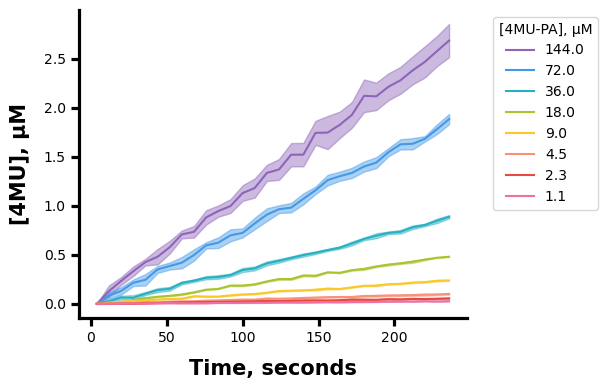

/home/donghyo/projects/ultra_optimized_single_zinc_esterase/design_campaign_ultra1_241122/kinetics_v2.py:418: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticklabels)


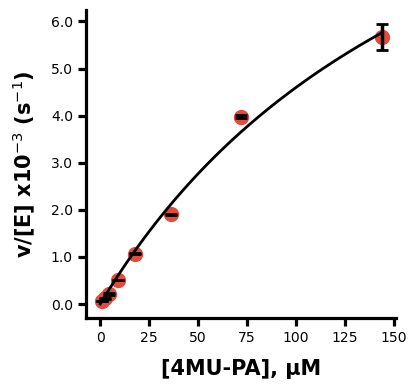

kcat:0.013617±0.001474s⁻¹
Km:196.22±32.24μM
kcat/Km: 69.40 ± 13.65 M⁻¹ s⁻¹

[SUBST] = 144.0uM, v0 = 5.666415773672388e-09
[SUBST] = 72.0uM, v0 = 3.977678896744639e-09
[SUBST] = 36.0uM, v0 = 1.900822116883578e-09
[SUBST] = 18.0uM, v0 = 1.0690104988087217e-09
[SUBST] = 9.0uM, v0 = 5.077782474611886e-10
[SUBST] = 4.5uM, v0 = 2.17495000843772e-10
[SUBST] = 2.3uM, v0 = 1.190234368995489e-10
[SUBST] = 1.1uM, v0 = 5.5732713456507803e-11


In [ ]:
### Input/Output File/Directiory ###
excel_file = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase/paper_data/240830_B9_OFFICIAL_kinetics_2uM___phenylacetate_subst_25C_4min_10x_zn.xlsx'
pics_dir = './pics/'
os.makedirs(pics_dir, exist_ok=True)

### Input Parameter ###
#slope = np.average([9.710399908638067e-10, 9.561887458844373e-10, 9.695313428289856e-10]) # NEW ONE - After removing the last two points
slope = np.average([9.296712951159367e-10, 9.447803716354774e-10, 9.40363467934009e-10]) # NEWEST ONE (250401)

enz_conc = 2.0
rows, cols = list("ABCDEFGH"), [5,6,7,8]
replicate_dic = {5: [6, 7]}
bg_col = 8
sub_concs = np.array([144, 72, 36, 18, 9, 4.5, 2.3, 1.1])              #[144, 72, 36, 18, 9, 4.5, 2.25, 1.125]
col_range_to_analyze = (1, 8)                                     # From 1st to 8th columns
start_time = 0
end_time = 240
substrate_name = '4MU-PA'

### Parameter Preprocessing ###
transpose_dic = make_transpose_dic(rows, cols)
rename_dic = make_rename_dic(transpose_dic, rows, cols)
represent_row = "A"
replicate_rows = ["ABCDEFGHIJKL"[cols.index(rep)] for rep in list(replicate_dic.values())[0]]
bg_row = "ABCDEFGHIJKL"[cols.index(bg_col)]
row_column_ranges = {represent_row: col_range_to_analyze}
active_wells = make_active_wells(row_column_ranges)

### Data Parsing/Plotting ###
bn = os.path.basename(f'{excel_file}').replace('.xlsx','')
kinetic_data = parse_kinetics(excel_file, active_wells, start_row=48)
kinetic_data.rename(columns=rename_dic, inplace=True)
v0_enz = mm_kinetics(kinetic_data, bn, rows, cols, active_wells, bg_row, enz_conc, sub_concs, substrate_name, pics_dir, replicate_rows, fit_type='straight_line', slope=slope,
            cutoff_start_time=start_time, cutoff_end_time=end_time, plate_type='full', y_ax_mm_intv=0.1, x_ax_mm_intv=50, legend_label=f'[{substrate_name}], μM', norm_zero=True)


### II.II.D. 240927 C4 Kinetics ([E]<sub>0</sub> = 3μM; [Zn(II)] = 10μM; Temp = 25C)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


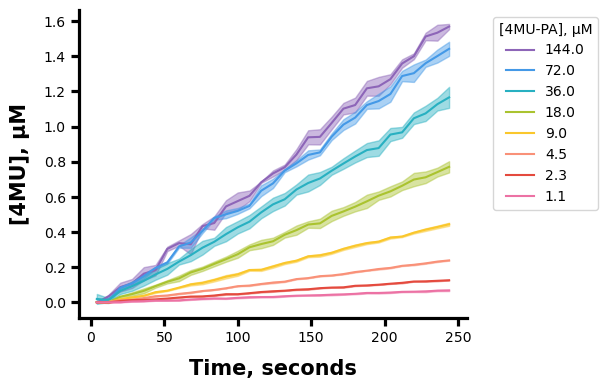

/home/donghyo/projects/ultra_optimized_single_zinc_esterase/design_campaign_ultra1_241122/kinetics_v2.py:418: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticklabels)


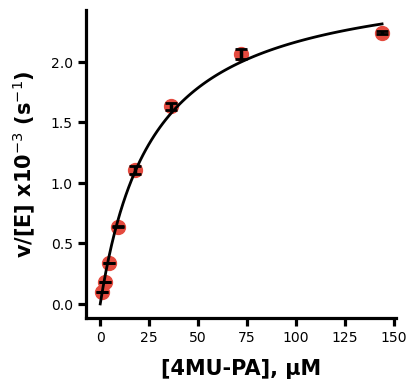

kcat:0.002747±0.000053s⁻¹
Km:26.87±1.46μM
kcat/Km: 102.24 ± 5.90 M⁻¹ s⁻¹

[SUBST] = 144.0uM, v0 = 2.244006903529243e-09
[SUBST] = 72.0uM, v0 = 2.066063168984389e-09
[SUBST] = 36.0uM, v0 = 1.6323647259654294e-09
[SUBST] = 18.0uM, v0 = 1.1076188258103175e-09
[SUBST] = 9.0uM, v0 = 6.371850695323495e-10
[SUBST] = 4.5uM, v0 = 3.3997111036255254e-10
[SUBST] = 2.3uM, v0 = 1.8101245474843833e-10
[SUBST] = 1.1uM, v0 = 9.775765525255303e-11


In [ ]:
### Input/Output File/Directiory ###
excel_file = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase/paper_data/240927_C4_FINAL_kinetics_3uM___phenylacetate_subst_25C_5min_10uM_zn_144uMsubstLadder.xlsx'
pics_dir = './pics/'
os.makedirs(pics_dir, exist_ok=True)

### Input Parameter ###
#slope = np.average([9.710399908638067e-10, 9.561887458844373e-10, 9.695313428289856e-10]) # NEW ONE - After removing the last two points
slope = np.average([9.296712951159367e-10, 9.447803716354774e-10, 9.40363467934009e-10]) # NEWEST ONE (250401)

enz_conc = 3.0
rows, cols = list("ABCDEFGH"), [9,10,11,12]
replicate_dic = {9: [10, 11]}
bg_col = 12
sub_concs = np.array([144, 72, 36, 18, 9, 4.5, 2.3, 1.1])              #[144, 72, 36, 18, 9, 4.5, 2.25, 1.125]
col_range_to_analyze = (1, 8)                                     # From 1st to 8th columns
start_time = 0
end_time = 600
substrate_name = '4MU-PA'

### Parameter Preprocessing ###
transpose_dic = make_transpose_dic(rows, cols)
rename_dic = make_rename_dic(transpose_dic, rows, cols)
represent_row = "A"
replicate_rows = ["ABCDEFGHIJKL"[cols.index(rep)] for rep in list(replicate_dic.values())[0]]
bg_row = "ABCDEFGHIJKL"[cols.index(bg_col)]
row_column_ranges = {represent_row: col_range_to_analyze}
active_wells = make_active_wells(row_column_ranges)

### Data Parsing/Plotting ###
bn = os.path.basename(f'{excel_file}').replace('.xlsx','')
kinetic_data = parse_kinetics(excel_file, active_wells, start_row=48)
kinetic_data.rename(columns=rename_dic, inplace=True)
v0_enz = mm_kinetics(kinetic_data, bn, rows, cols, active_wells, bg_row, enz_conc, sub_concs, substrate_name, pics_dir, replicate_rows, fit_type='straight_line', slope=slope,
            cutoff_start_time=start_time, cutoff_end_time=end_time, plate_type='full', y_ax_mm_intv=0.1, x_ax_mm_intv=50, legend_label=f'[{substrate_name}], μM', norm_zero=True)


### II.II.E. 240830 F7 Kinetics ([E]<sub>0</sub> = 2μM; [Zn(II)] = 10μM; Temp = 25C)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


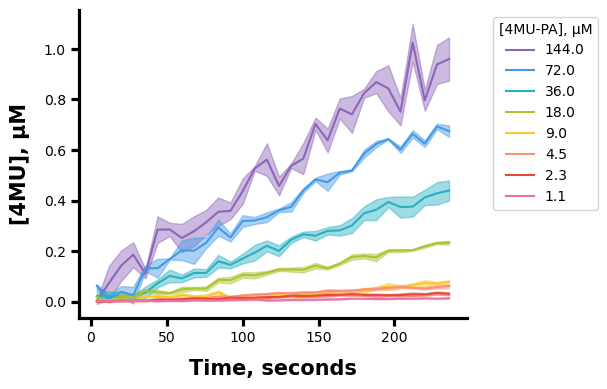

/home/donghyo/projects/ultra_optimized_single_zinc_esterase/design_campaign_ultra1_241122/kinetics_v2.py:418: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticklabels)


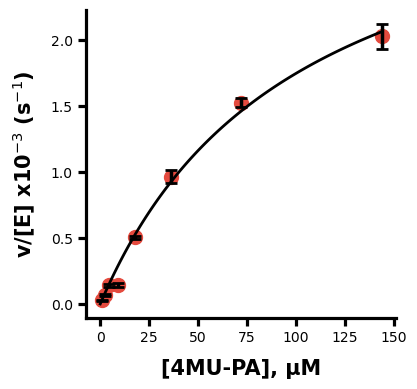

kcat:0.003515±0.000248s⁻¹
Km:101.20±13.26μM
kcat/Km: 34.73 ± 5.17 M⁻¹ s⁻¹

[SUBST] = 144.0uM, v0 = 2.02799498457413e-09
[SUBST] = 72.0uM, v0 = 1.52643100424226e-09
[SUBST] = 36.0uM, v0 = 9.640333060153305e-10
[SUBST] = 18.0uM, v0 = 5.03747018889545e-10
[SUBST] = 9.0uM, v0 = 1.41714861588692e-10
[SUBST] = 4.5uM, v0 = 1.396579348202051e-10
[SUBST] = 2.3uM, v0 = 6.850479362362421e-11
[SUBST] = 1.1uM, v0 = 2.707489653403696e-11


In [ ]:
### Input/Output File/Directiory ###
excel_file = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase/paper_data/240830_F7_OFFICIAL_kinetics_2uM___phenylacetate_subst_25C_4min_10x_zn.xlsx'
pics_dir = './pics/'
os.makedirs(pics_dir, exist_ok=True)

### Input Parameter ###
#slope = np.average([9.710399908638067e-10, 9.561887458844373e-10, 9.695313428289856e-10]) # NEW ONE - After removing the last two points
slope = np.average([9.296712951159367e-10, 9.447803716354774e-10, 9.40363467934009e-10]) # NEWEST ONE (250401)

enz_conc = 2.0
rows, cols = list("ABCDEFGH"), [9,10,11,12]
replicate_dic = {9: [10, 11]}
bg_col = 12
sub_concs = np.array([144, 72, 36, 18, 9, 4.5, 2.3, 1.1])              #[144, 72, 36, 18, 9, 4.5, 2.25, 1.125]
col_range_to_analyze = (1, 8)                                     # From 1st to 8th columns
start_time = 0
end_time = 240
substrate_name = '4MU-PA'

### Parameter Preprocessing ###
transpose_dic = make_transpose_dic(rows, cols)
rename_dic = make_rename_dic(transpose_dic, rows, cols)
represent_row = "A"
replicate_rows = ["ABCDEFGHIJKL"[cols.index(rep)] for rep in list(replicate_dic.values())[0]]
bg_row = "ABCDEFGHIJKL"[cols.index(bg_col)]
row_column_ranges = {represent_row: col_range_to_analyze}
active_wells = make_active_wells(row_column_ranges)

### Data Parsing/Plotting ###
bn = os.path.basename(f'{excel_file}').replace('.xlsx','')
kinetic_data = parse_kinetics(excel_file, active_wells, start_row=48)
kinetic_data.rename(columns=rename_dic, inplace=True)
v0_enz = mm_kinetics(kinetic_data, bn, rows, cols, active_wells, bg_row, enz_conc, sub_concs, substrate_name, pics_dir, replicate_rows, fit_type='straight_line', slope=slope,
            cutoff_start_time=start_time, cutoff_end_time=end_time, plate_type='full', y_ax_mm_intv=0.1, x_ax_mm_intv=50, legend_label=f'[{substrate_name}], μM', norm_zero=True)


## II.III. Michaelis-Menten Kinetics for Top 11 Design Campaign 2 Hits (3 Unique RFdiffusion2 Scaffolds)



### II.III.A. 250325 ZETA_2 (H10) Kinetics ([E]<sub>0</sub> = 100nM; [Zn(II)] = 1μM; Temp = 25C)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


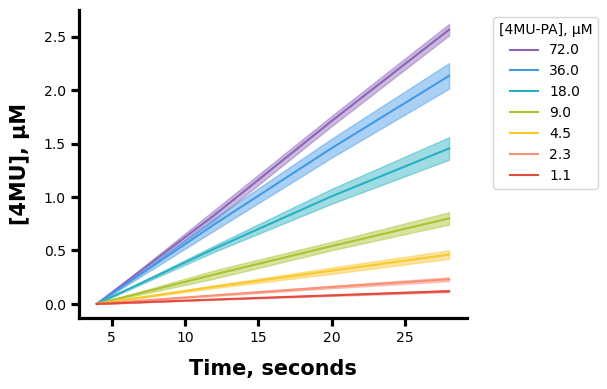

/home/donghyo/projects/ultra_optimized_single_zinc_esterase/design_campaign_ultra1_241122/kinetics_v2.py:418: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticklabels)


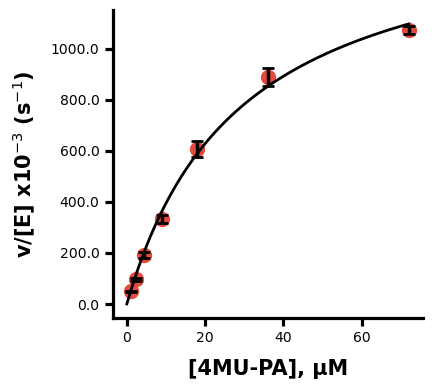

kcat:1.537782±0.061227s⁻¹
Km:28.99±2.57μM
kcat/Km: 53041.53 ± 5149.12 M⁻¹ s⁻¹

[SUBST] = 72.0uM, v0 = 1.072522755624443e-06
[SUBST] = 36.0uM, v0 = 8.895597718698904e-07
[SUBST] = 18.0uM, v0 = 6.06827229452599e-07
[SUBST] = 9.0uM, v0 = 3.334383094962774e-07
[SUBST] = 4.5uM, v0 = 1.9183747035974126e-07
[SUBST] = 2.3uM, v0 = 9.632922905367891e-08
[SUBST] = 1.1uM, v0 = 4.96893060581274e-08


In [ ]:
### Input/Output File/Directiory ###
excel_file = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase_ULTRAop/single_zinc_esterase/250325_H10_1xZn_kinetics_100nM___phenylacetate_subst_25C_5min_10x_zn_144uMsubstLadder.xlsx'
pics_dir = './pics/'
os.makedirs(pics_dir, exist_ok=True)

### Input Parameter ###
#slope = np.average([9.710399908638067e-10, 9.561887458844373e-10, 9.695313428289856e-10]) # NEW ONE - After removing the last two points
slope = np.average([9.296712951159367e-10, 9.447803716354774e-10, 9.40363467934009e-10]) # NEWEST ONE (250401)

enz_conc = 0.1
rows, cols = list("ABCDEFGH"), [1,2,3,4]
replicate_dic = {1: [2, 3]}
bg_col = 4
sub_concs = np.array([72, 36, 18, 9, 4.5, 2.3, 1.1])              #[144, 72, 36, 18, 9, 4.5, 2.25, 1.125]
col_range_to_analyze = (2, 8)                                     # From 2nd to 8th columns
start_time = 0
end_time = 30
substrate_name = '4MU-PA'

### Parameter Preprocessing ###
transpose_dic = make_transpose_dic(rows, cols)
rename_dic = make_rename_dic(transpose_dic, rows, cols)
represent_row = "A"
replicate_rows = ["ABCDEFGHIJKL"[cols.index(rep)] for rep in list(replicate_dic.values())[0]]
bg_row = "ABCDEFGHIJKL"[cols.index(bg_col)]
row_column_ranges = {represent_row: col_range_to_analyze}
active_wells = make_active_wells(row_column_ranges)

### Data Parsing/Plotting ###
bn = os.path.basename(f'{excel_file}').replace('.xlsx','')
kinetic_data = parse_kinetics(excel_file, active_wells, start_row=48)
kinetic_data.rename(columns=rename_dic, inplace=True)
v0_enz = mm_kinetics(kinetic_data, bn, rows, cols, active_wells, bg_row, enz_conc, sub_concs, substrate_name, pics_dir, replicate_rows, fit_type='straight_line', slope=slope,
            cutoff_start_time=start_time, cutoff_end_time=end_time, plate_type='full', y_ax_mm_intv=0.1, x_ax_mm_intv=50, legend_label=f'[{substrate_name}], μM', norm_zero=True)


### II.III.B. 250318 F11 Kinetics ([E]<sub>0</sub> = 100nM; [Zn(II)] = 1μM; Temp = 25C)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


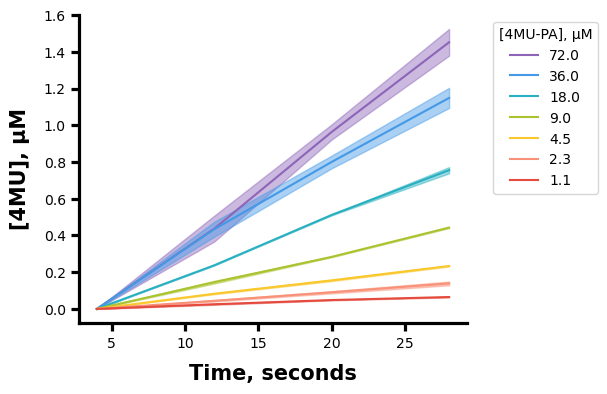

/home/donghyo/projects/ultra_optimized_single_zinc_esterase/design_campaign_ultra1_241122/kinetics_v2.py:418: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticklabels)


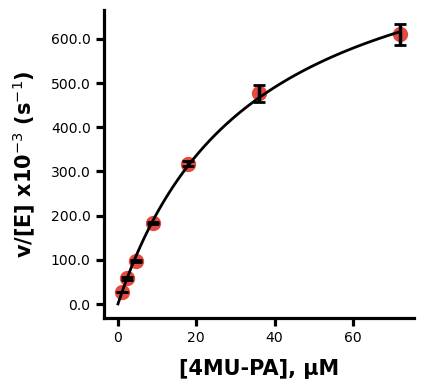

kcat:0.907012±0.033225s⁻¹
Km:33.99±2.63μM
kcat/Km: 26681.80 ± 2284.14 M⁻¹ s⁻¹

[SUBST] = 72.0uM, v0 = 6.102871063889831e-07
[SUBST] = 36.0uM, v0 = 4.7664202947339826e-07
[SUBST] = 18.0uM, v0 = 3.1754633238169927e-07
[SUBST] = 9.0uM, v0 = 1.8331483564638816e-07
[SUBST] = 4.5uM, v0 = 9.670062827283879e-08
[SUBST] = 2.3uM, v0 = 5.787963620696901e-08
[SUBST] = 1.1uM, v0 = 2.7151237653319807e-08


In [ ]:
### Input/Output File/Directiory ###
excel_file = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase_ULTRAop/single_zinc_esterase/250318_F11_1xZn_kinetics_100nM___phenylacetate_subst_25C_5min_10x_zn_144uMsubstLadder.xlsx'
pics_dir = './pics/'
os.makedirs(pics_dir, exist_ok=True)

### Input Parameter ###
#slope = np.average([1.3520814422260207e-09, 1.3922256043348527e-09, 1.396380732487886e-09]) # PREVIOUS ONE
#slope = np.average([1.133032096136289e-09, 1.0876356379096542e-09, 1.097352870642798e-09]) # NEW ONE
slope = np.average([9.296712951159367e-10, 9.447803716354774e-10, 9.40363467934009e-10]) # NEWEST ONE (250401)
enz_conc = 0.1
rows, cols = list("ABCDEFGH"), [5,6,7,8]
replicate_dic = {5: [7]}
bg_col = 8
sub_concs = np.array([72, 36, 18, 9, 4.5, 2.3, 1.1])              #[144, 72, 36, 18, 9, 4.5, 2.25, 1.125]
col_range_to_analyze = (2, 8)                                     # From 2nd to 8th columns
start_time = 0
end_time = 30
substrate_name = '4MU-PA'

### Parameter Preprocessing ###
transpose_dic = make_transpose_dic(rows, cols)
rename_dic = make_rename_dic(transpose_dic, rows, cols)
represent_row = "A"
replicate_rows = ["ABCDEFGHIJKL"[cols.index(rep)] for rep in list(replicate_dic.values())[0]]
bg_row = "ABCDEFGHIJKL"[cols.index(bg_col)]
row_column_ranges = {represent_row: col_range_to_analyze}
active_wells = make_active_wells(row_column_ranges)

### Data Parsing/Plotting ###
bn = os.path.basename(f'{excel_file}').replace('.xlsx','')
kinetic_data = parse_kinetics(excel_file, active_wells, start_row=48)
kinetic_data.rename(columns=rename_dic, inplace=True)
v0_enz = mm_kinetics(kinetic_data, bn, rows, cols, active_wells, bg_row, enz_conc, sub_concs, substrate_name, pics_dir, replicate_rows, fit_type='straight_line', slope=slope,
            cutoff_start_time=start_time, cutoff_end_time=end_time, plate_type='full', y_ax_mm_intv=0.1, x_ax_mm_intv=50, legend_label=f'[{substrate_name}], μM', norm_zero=True)

### II.III.C. 250327 H1 Kinetics ([E]<sub>0</sub> = 100nM; [Zn(II)] = 1μM; Temp = 25C)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


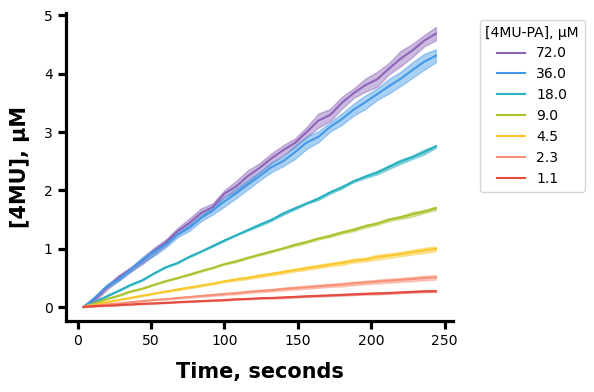

/home/donghyo/projects/ultra_optimized_single_zinc_esterase/design_campaign_ultra1_241122/kinetics_v2.py:418: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticklabels)


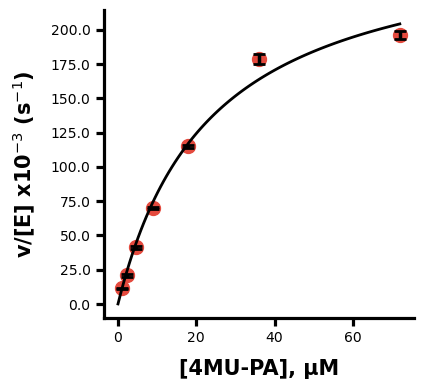

kcat:0.271458±0.010413s⁻¹
Km:23.67±2.15μM
kcat/Km: 11469.82 ± 1132.51 M⁻¹ s⁻¹

[SUBST] = 72.0uM, v0 = 1.9611581280795822e-07
[SUBST] = 36.0uM, v0 = 1.7894049059865148e-07
[SUBST] = 18.0uM, v0 = 1.149409645418417e-07
[SUBST] = 9.0uM, v0 = 6.997549082723934e-08
[SUBST] = 4.5uM, v0 = 4.119457357813223e-08
[SUBST] = 2.3uM, v0 = 2.0985789919634678e-08
[SUBST] = 1.1uM, v0 = 1.1284482896579374e-08


In [ ]:
### Input/Output File/Directiory ###
excel_file = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase_ULTRAop/single_zinc_esterase/250327_H1_1xZn_kinetics_100nM___phenylacetate_subst_25C_5min_10x_zn_144uMsubstLadder.xlsx'
pics_dir = './pics/'
os.makedirs(pics_dir, exist_ok=True)

### Input Parameter ###
#slope = np.average([9.710399908638067e-10, 9.561887458844373e-10, 9.695313428289856e-10]) # NEW ONE - After removing the last two points
slope = np.average([9.296712951159367e-10, 9.447803716354774e-10, 9.40363467934009e-10]) # NEWEST ONE (250401)

enz_conc = 0.1
rows, cols = list("ABCDEFGH"), [1,2,3,4]
replicate_dic = {1: [2, 3]}
bg_col = 4
sub_concs = np.array([72, 36, 18, 9, 4.5, 2.3, 1.1])              #[144, 72, 36, 18, 9, 4.5, 2.25, 1.125]
col_range_to_analyze = (2, 8)                                     # From 2nd to 8th columns
start_time = 0
end_time = 1200
substrate_name = '4MU-PA'

### Parameter Preprocessing ###
transpose_dic = make_transpose_dic(rows, cols)
rename_dic = make_rename_dic(transpose_dic, rows, cols)
represent_row = "A"
replicate_rows = ["ABCDEFGHIJKL"[cols.index(rep)] for rep in list(replicate_dic.values())[0]]
bg_row = "ABCDEFGHIJKL"[cols.index(bg_col)]
row_column_ranges = {represent_row: col_range_to_analyze}
active_wells = make_active_wells(row_column_ranges)

### Data Parsing/Plotting ###
bn = os.path.basename(f'{excel_file}').replace('.xlsx','')
kinetic_data = parse_kinetics(excel_file, active_wells, start_row=48)
kinetic_data.rename(columns=rename_dic, inplace=True)
v0_enz = mm_kinetics(kinetic_data, bn, rows, cols, active_wells, bg_row, enz_conc, sub_concs, substrate_name, pics_dir, replicate_rows, fit_type='straight_line', slope=slope,
            cutoff_start_time=start_time, cutoff_end_time=end_time, plate_type='full', y_ax_mm_intv=0.1, x_ax_mm_intv=50, legend_label=f'[{substrate_name}], μM', norm_zero=True)


### II.III.D. 250327 F8 Kinetics ([E]<sub>0</sub> = 100nM; [Zn(II)] = 1μM; Temp = 25C)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


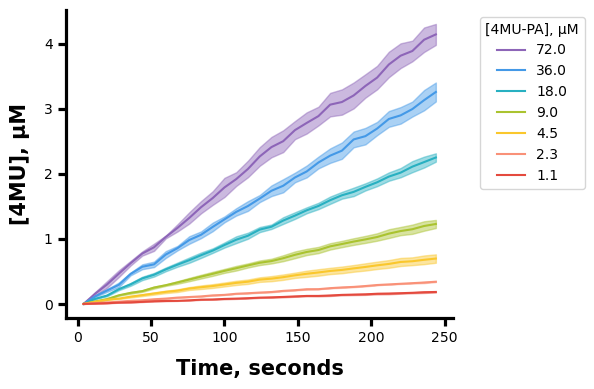

/home/donghyo/projects/ultra_optimized_single_zinc_esterase/design_campaign_ultra1_241122/kinetics_v2.py:418: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticklabels)


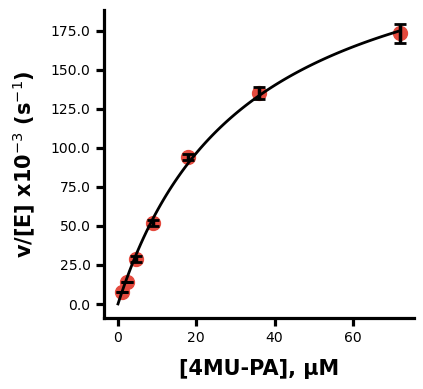

kcat:0.254271±0.009192s⁻¹
Km:32.64±2.53μM
kcat/Km: 7789.87 ± 665.23 M⁻¹ s⁻¹

[SUBST] = 72.0uM, v0 = 1.7332536318503733e-07
[SUBST] = 36.0uM, v0 = 1.3519262620866326e-07
[SUBST] = 18.0uM, v0 = 9.401854579627417e-08
[SUBST] = 9.0uM, v0 = 5.170488772883124e-08
[SUBST] = 4.5uM, v0 = 2.8750965699174855e-08
[SUBST] = 2.3uM, v0 = 1.424763702329767e-08
[SUBST] = 1.1uM, v0 = 7.678001005263674e-09


In [ ]:
### Input/Output File/Directiory ###
excel_file = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase_ULTRAop/single_zinc_esterase/250327_F8_1xZn_kinetics_100nM___phenylacetate_subst_25C_5min_10x_zn_144uMsubstLadder.xlsx'
pics_dir = './pics/'
os.makedirs(pics_dir, exist_ok=True)

### Input Parameter ###
#slope = np.average([9.710399908638067e-10, 9.561887458844373e-10, 9.695313428289856e-10]) # NEW ONE - After removing the last two points
slope = np.average([9.296712951159367e-10, 9.447803716354774e-10, 9.40363467934009e-10]) # NEWEST ONE (250401)

enz_conc = 0.1
rows, cols = list("ABCDEFGH"), [5,6,7,8]
replicate_dic = {5: [6, 7]}
bg_col = 8
sub_concs = np.array([72, 36, 18, 9, 4.5, 2.3, 1.1])              #[144, 72, 36, 18, 9, 4.5, 2.25, 1.125]
col_range_to_analyze = (2, 8)                                     # From 2nd to 8th columns
start_time = 0
end_time = 1200
substrate_name = '4MU-PA'

### Parameter Preprocessing ###
transpose_dic = make_transpose_dic(rows, cols)
rename_dic = make_rename_dic(transpose_dic, rows, cols)
represent_row = "A"
replicate_rows = ["ABCDEFGHIJKL"[cols.index(rep)] for rep in list(replicate_dic.values())[0]]
bg_row = "ABCDEFGHIJKL"[cols.index(bg_col)]
row_column_ranges = {represent_row: col_range_to_analyze}
active_wells = make_active_wells(row_column_ranges)

### Data Parsing/Plotting ###
bn = os.path.basename(f'{excel_file}').replace('.xlsx','')
kinetic_data = parse_kinetics(excel_file, active_wells, start_row=48)
kinetic_data.rename(columns=rename_dic, inplace=True)
v0_enz = mm_kinetics(kinetic_data, bn, rows, cols, active_wells, bg_row, enz_conc, sub_concs, substrate_name, pics_dir, replicate_rows, fit_type='straight_line', slope=slope,
            cutoff_start_time=start_time, cutoff_end_time=end_time, plate_type='full', y_ax_mm_intv=0.1, x_ax_mm_intv=50, legend_label=f'[{substrate_name}], μM', norm_zero=True)


### II.III.E. 250327 F2 Kinetics ([E]<sub>0</sub> = 100nM; [Zn(II)] = 1μM; Temp = 25C) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


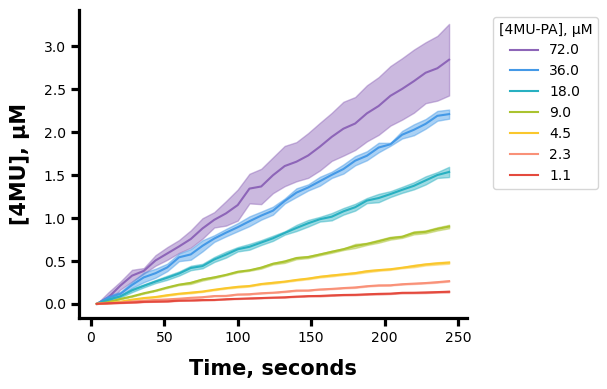

/home/donghyo/projects/ultra_optimized_single_zinc_esterase/design_campaign_ultra1_241122/kinetics_v2.py:418: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticklabels)


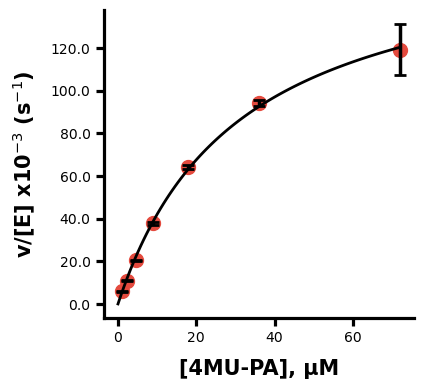

kcat:0.172024±0.011713s⁻¹
Km:30.90±4.58μM
kcat/Km: 5567.86 ± 908.76 M⁻¹ s⁻¹

[SUBST] = 72.0uM, v0 = 1.1931310263326754e-07
[SUBST] = 36.0uM, v0 = 9.418990018983393e-08
[SUBST] = 18.0uM, v0 = 6.42927359666729e-08
[SUBST] = 9.0uM, v0 = 3.778088508453834e-08
[SUBST] = 4.5uM, v0 = 2.039479854755047e-08
[SUBST] = 2.3uM, v0 = 1.0972986777283988e-08
[SUBST] = 1.1uM, v0 = 5.9154311116190905e-09


In [ ]:
### Input/Output File/Directiory ###
excel_file = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase_ULTRAop/single_zinc_esterase/250327_F2_1xZn_kinetics_100nM___phenylacetate_subst_25C_5min_10x_zn_144uMsubstLadder.xlsx'
pics_dir = './pics/'
os.makedirs(pics_dir, exist_ok=True)

### Input Parameter ###
#slope = np.average([9.710399908638067e-10, 9.561887458844373e-10, 9.695313428289856e-10]) # NEW ONE - After removing the last two points
slope = np.average([9.296712951159367e-10, 9.447803716354774e-10, 9.40363467934009e-10]) # NEWEST ONE (250401)

enz_conc = 0.1
rows, cols = list("ABCDEFGH"), [5,6,7,8]
replicate_dic = {5: [6, 7]}
bg_col = 8
sub_concs = np.array([72, 36, 18, 9, 4.5, 2.3, 1.1])              #[144, 72, 36, 18, 9, 4.5, 2.25, 1.125]
col_range_to_analyze = (2, 8)                                     # From 2nd to 8th columns
start_time = 0
end_time = 1200
substrate_name = '4MU-PA'

### Parameter Preprocessing ###
transpose_dic = make_transpose_dic(rows, cols)
rename_dic = make_rename_dic(transpose_dic, rows, cols)
represent_row = "A"
replicate_rows = ["ABCDEFGHIJKL"[cols.index(rep)] for rep in list(replicate_dic.values())[0]]
bg_row = "ABCDEFGHIJKL"[cols.index(bg_col)]
row_column_ranges = {represent_row: col_range_to_analyze}
active_wells = make_active_wells(row_column_ranges)

### Data Parsing/Plotting ###
bn = os.path.basename(f'{excel_file}').replace('.xlsx','')
kinetic_data = parse_kinetics(excel_file, active_wells, start_row=48)
kinetic_data.rename(columns=rename_dic, inplace=True)
v0_enz = mm_kinetics(kinetic_data, bn, rows, cols, active_wells, bg_row, enz_conc, sub_concs, substrate_name, pics_dir, replicate_rows, fit_type='straight_line', slope=slope,
            cutoff_start_time=start_time, cutoff_end_time=end_time, plate_type='full', y_ax_mm_intv=0.1, x_ax_mm_intv=50, legend_label=f'[{substrate_name}], μM', norm_zero=True)


### II.III.F. 250327 F7 Kinetics ([E]<sub>0</sub> = 500nM; [Zn(II)] = 5μM; Temp = 25C) (BONUS DATA)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


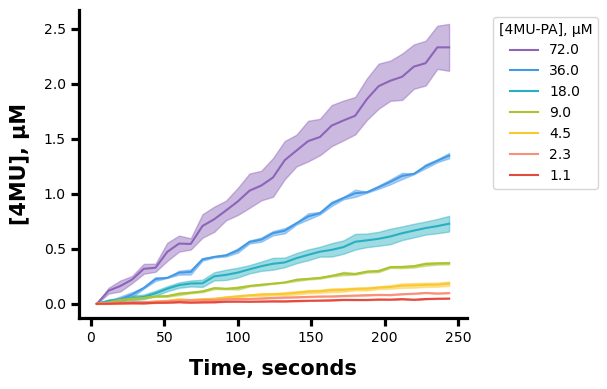

/home/donghyo/projects/ultra_optimized_single_zinc_esterase/design_campaign_ultra1_241122/kinetics_v2.py:418: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticklabels)


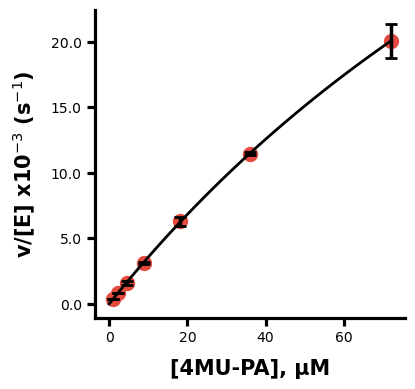

kcat:0.078882±0.017701s⁻¹
Km:210.80±59.93μM
kcat/Km: 374.20 ± 135.53 M⁻¹ s⁻¹

[SUBST] = 72.0uM, v0 = 2.0083365484149685e-08
[SUBST] = 36.0uM, v0 = 1.1483550355813285e-08
[SUBST] = 18.0uM, v0 = 6.3086476703085684e-09
[SUBST] = 9.0uM, v0 = 3.1445974634131275e-09
[SUBST] = 4.5uM, v0 = 1.6156181312927849e-09
[SUBST] = 2.3uM, v0 = 8.048454386004646e-10
[SUBST] = 1.1uM, v0 = 3.8514540418141944e-10


In [ ]:
### Input/Output File/Directiory ###
excel_file = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase_ULTRAop/single_zinc_esterase/250327_F7_1xZn_kinetics_500nM___phenylacetate_subst_25C_5min_10x_zn_144uMsubstLadder.xlsx'
pics_dir = './pics/'
os.makedirs(pics_dir, exist_ok=True)

### Input Parameter ###
#slope = np.average([9.710399908638067e-10, 9.561887458844373e-10, 9.695313428289856e-10]) # NEW ONE - After removing the last two points
slope = np.average([9.296712951159367e-10, 9.447803716354774e-10, 9.40363467934009e-10]) # NEWEST ONE (250401)

enz_conc = 0.5
rows, cols = list("ABCDEFGH"), [5,6,7,8]
replicate_dic = {5: [6, 7]}
bg_col = 8
sub_concs = np.array([72, 36, 18, 9, 4.5, 2.3, 1.1])              #[144, 72, 36, 18, 9, 4.5, 2.25, 1.125]
col_range_to_analyze = (2, 8)                                     # From 2nd to 8th columns
start_time = 0
end_time = 1200
substrate_name = '4MU-PA'

### Parameter Preprocessing ###
transpose_dic = make_transpose_dic(rows, cols)
rename_dic = make_rename_dic(transpose_dic, rows, cols)
represent_row = "A"
replicate_rows = ["ABCDEFGHIJKL"[cols.index(rep)] for rep in list(replicate_dic.values())[0]]
bg_row = "ABCDEFGHIJKL"[cols.index(bg_col)]
row_column_ranges = {represent_row: col_range_to_analyze}
active_wells = make_active_wells(row_column_ranges)

### Data Parsing/Plotting ###
bn = os.path.basename(f'{excel_file}').replace('.xlsx','')
kinetic_data = parse_kinetics(excel_file, active_wells, start_row=48)
kinetic_data.rename(columns=rename_dic, inplace=True)
v0_enz = mm_kinetics(kinetic_data, bn, rows, cols, active_wells, bg_row, enz_conc, sub_concs, substrate_name, pics_dir, replicate_rows, fit_type='straight_line', slope=slope,
            cutoff_start_time=start_time, cutoff_end_time=end_time, plate_type='full', y_ax_mm_intv=0.1, x_ax_mm_intv=50, legend_label=f'[{substrate_name}], μM', norm_zero=True)


### II.III.G. 250318 ZETA_3 (H6) Kinetics ([E]<sub>0</sub> = 100nM; [Zn(II)] = 1μM; Temp = 25C)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


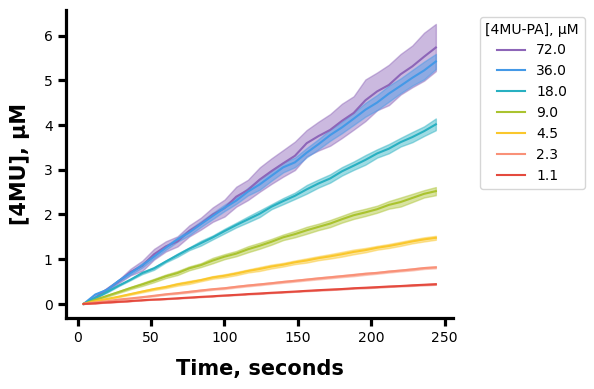

/home/donghyo/projects/ultra_optimized_single_zinc_esterase/design_campaign_ultra1_241122/kinetics_v2.py:418: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticklabels)


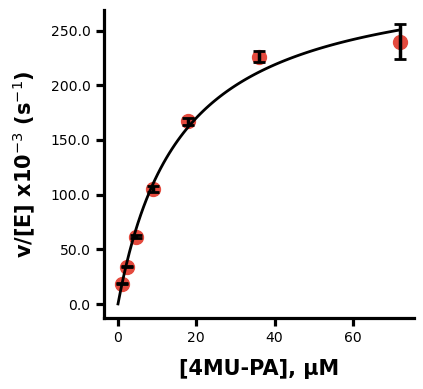

kcat:0.306310±0.012562s⁻¹
Km:16.02±1.76μM
kcat/Km: 19119.02 ± 2236.76 M⁻¹ s⁻¹

[SUBST] = 72.0uM, v0 = 2.3983057285328443e-07
[SUBST] = 36.0uM, v0 = 2.2613877354083475e-07
[SUBST] = 18.0uM, v0 = 1.6688893274433356e-07
[SUBST] = 9.0uM, v0 = 1.0550843326949416e-07
[SUBST] = 4.5uM, v0 = 6.137056817144081e-08
[SUBST] = 2.3uM, v0 = 3.405601575112201e-08
[SUBST] = 1.1uM, v0 = 1.845945550271776e-08


In [ ]:
### Input/Output File/Directiory ###
excel_file = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase_ULTRAop/single_zinc_esterase/250318_H6_1xZn_kinetics_100nM___phenylacetate_subst_25C_5min_10x_zn_144uMsubstLadder.xlsx'
pics_dir = './pics/'
os.makedirs(pics_dir, exist_ok=True)

### Input Parameter ###
#slope = np.average([9.710399908638067e-10, 9.561887458844373e-10, 9.695313428289856e-10]) # NEW ONE - After removing the last two points
slope = np.average([9.296712951159367e-10, 9.447803716354774e-10, 9.40363467934009e-10]) # NEWEST ONE (250401)

enz_conc = 0.1
rows, cols = list("ABCDEFGH"), [5,6,7,8]
replicate_dic = {5: [6, 7]}
bg_col = 8
sub_concs = np.array([72, 36, 18, 9, 4.5, 2.3, 1.1])              #[144, 72, 36, 18, 9, 4.5, 2.25, 1.125]
col_range_to_analyze = (2, 8)                                     # From 2nd to 8th columns
start_time = 0
end_time = 1200
substrate_name = '4MU-PA'

### Parameter Preprocessing ###
transpose_dic = make_transpose_dic(rows, cols)
rename_dic = make_rename_dic(transpose_dic, rows, cols)
represent_row = "A"
replicate_rows = ["ABCDEFGHIJKL"[cols.index(rep)] for rep in list(replicate_dic.values())[0]]
bg_row = "ABCDEFGHIJKL"[cols.index(bg_col)]
row_column_ranges = {represent_row: col_range_to_analyze}
active_wells = make_active_wells(row_column_ranges)

### Data Parsing/Plotting ###
bn = os.path.basename(f'{excel_file}').replace('.xlsx','')
kinetic_data = parse_kinetics(excel_file, active_wells, start_row=48)
kinetic_data.rename(columns=rename_dic, inplace=True)
v0_enz = mm_kinetics(kinetic_data, bn, rows, cols, active_wells, bg_row, enz_conc, sub_concs, substrate_name, pics_dir, replicate_rows, fit_type='straight_line', slope=slope,
            cutoff_start_time=start_time, cutoff_end_time=end_time, plate_type='full', y_ax_mm_intv=0.1, x_ax_mm_intv=50, legend_label=f'[{substrate_name}], μM', norm_zero=True)


### II.III.H. 250318 B10 Kinetics ([E]<sub>0</sub> = 100nM; [Zn(II)] = 1μM; Temp = 25C)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


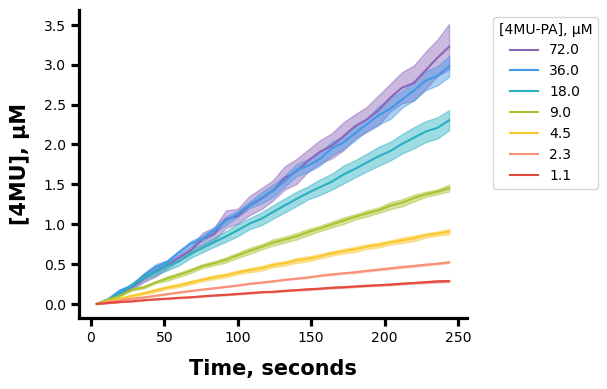

/home/donghyo/projects/ultra_optimized_single_zinc_esterase/design_campaign_ultra1_241122/kinetics_v2.py:418: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticklabels)


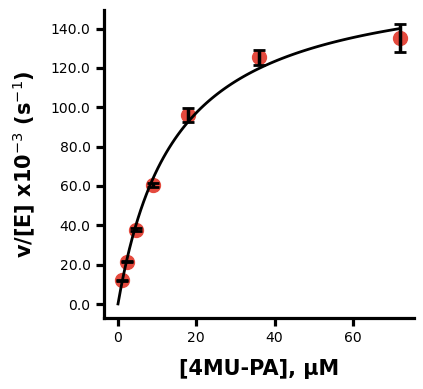

kcat:0.168582±0.005733s⁻¹
Km:14.70±1.37μM
kcat/Km: 11472.02 ± 1137.99 M⁻¹ s⁻¹

[SUBST] = 72.0uM, v0 = 1.3528011626241277e-07
[SUBST] = 36.0uM, v0 = 1.254988858929593e-07
[SUBST] = 18.0uM, v0 = 9.612051404257206e-08
[SUBST] = 9.0uM, v0 = 6.03170618125081e-08
[SUBST] = 4.5uM, v0 = 3.767841925582275e-08
[SUBST] = 2.3uM, v0 = 2.1526967134989468e-08
[SUBST] = 1.1uM, v0 = 1.1931594014852428e-08


In [ ]:
### Input/Output File/Directiory ###
excel_file = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase_ULTRAop/single_zinc_esterase/250318_B10_1xZn_kinetics_100nM___phenylacetate_subst_25C_5min_10x_zn_144uMsubstLadder.xlsx'
pics_dir = './pics/'
os.makedirs(pics_dir, exist_ok=True)

### Input Parameter ###
#slope = np.average([1.3520814422260207e-09, 1.3922256043348527e-09, 1.396380732487886e-09]) # PREVIOUS ONE
#slope = np.average([1.133032096136289e-09, 1.0876356379096542e-09, 1.097352870642798e-09]) # NEW ONE
slope = np.average([9.296712951159367e-10, 9.447803716354774e-10, 9.40363467934009e-10]) # NEWEST ONE (250401)
enz_conc = 0.1
rows, cols = list("ABCDEFGH"), [5,6,7,8]
replicate_dic = {5: [6, 7]}
bg_col = 8
sub_concs = np.array([72, 36, 18, 9, 4.5, 2.3, 1.1])              #[144, 72, 36, 18, 9, 4.5, 2.25, 1.125]
col_range_to_analyze = (2, 8)                                     # From 2nd to 8th columns
start_time = 0
end_time = 600
substrate_name = '4MU-PA'

### Parameter Preprocessing ###
transpose_dic = make_transpose_dic(rows, cols)
rename_dic = make_rename_dic(transpose_dic, rows, cols)
represent_row = "A"
replicate_rows = ["ABCDEFGHIJKL"[cols.index(rep)] for rep in list(replicate_dic.values())[0]]
bg_row = "ABCDEFGHIJKL"[cols.index(bg_col)]
row_column_ranges = {represent_row: col_range_to_analyze}
active_wells = make_active_wells(row_column_ranges)

### Data Parsing/Plotting ###
bn = os.path.basename(f'{excel_file}').replace('.xlsx','')
kinetic_data = parse_kinetics(excel_file, active_wells, start_row=48)
kinetic_data.rename(columns=rename_dic, inplace=True)
v0_enz = mm_kinetics(kinetic_data, bn, rows, cols, active_wells, bg_row, enz_conc, sub_concs, substrate_name, pics_dir, replicate_rows, fit_type='straight_line', slope=slope,
            cutoff_start_time=start_time, cutoff_end_time=end_time, plate_type='full', y_ax_mm_intv=0.1, x_ax_mm_intv=50, legend_label=f'[{substrate_name}], μM', norm_zero=True)

### II.III.I. 250327 B5 Kinetics ([E]<sub>0</sub> = 500nM; [Zn(II)] = 5μM; Temp = 25C)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


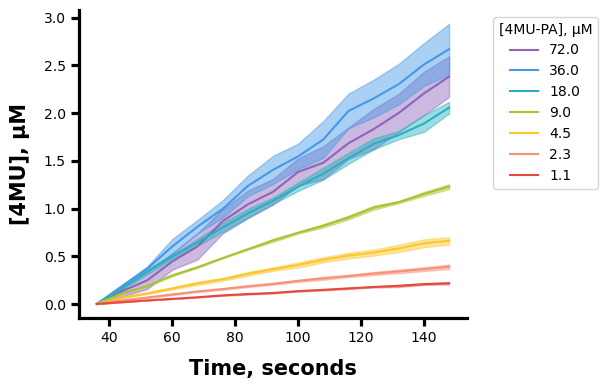

/home/donghyo/projects/ultra_optimized_single_zinc_esterase/design_campaign_ultra1_241122/kinetics_v2.py:418: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticklabels)


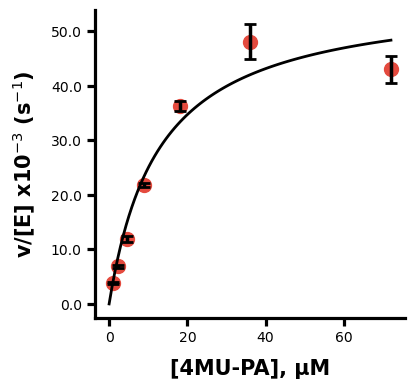

kcat:0.057023±0.003754s⁻¹
Km:12.81±2.40μM
kcat/Km: 4450.40 ± 884.89 M⁻¹ s⁻¹

[SUBST] = 72.0uM, v0 = 4.3086777383077584e-08
[SUBST] = 36.0uM, v0 = 4.8145904942114866e-08
[SUBST] = 18.0uM, v0 = 3.63728289422798e-08
[SUBST] = 9.0uM, v0 = 2.189021412777681e-08
[SUBST] = 4.5uM, v0 = 1.1874722101920925e-08
[SUBST] = 2.3uM, v0 = 6.892108366981242e-09
[SUBST] = 1.1uM, v0 = 3.870929305258862e-09


In [ ]:
### Input/Output File/Directiory ###
excel_file = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase_ULTRAop/single_zinc_esterase/250327_B5_1xZn_kinetics_500nM___phenylacetate_subst_25C_5min_10x_zn_144uMsubstLadder.xlsx'
pics_dir = './pics/'
os.makedirs(pics_dir, exist_ok=True)

### Input Parameter ###
#slope = np.average([9.710399908638067e-10, 9.561887458844373e-10, 9.695313428289856e-10]) # NEW ONE - After removing the last two points
slope = np.average([9.296712951159367e-10, 9.447803716354774e-10, 9.40363467934009e-10]) # NEWEST ONE (250401)

enz_conc = 0.5
rows, cols = list("ABCDEFGH"), [9,10,11,12]
replicate_dic = {9: [10, 11]}
bg_col = 12
sub_concs = np.array([72, 36, 18, 9, 4.5, 2.3, 1.1])              #[144, 72, 36, 18, 9, 4.5, 2.25, 1.125]
col_range_to_analyze = (2, 8)                                     # From 2nd to 8th columns
start_time = 30
end_time = 150
substrate_name = '4MU-PA'

### Parameter Preprocessing ###
transpose_dic = make_transpose_dic(rows, cols)
rename_dic = make_rename_dic(transpose_dic, rows, cols)
represent_row = "A"
replicate_rows = ["ABCDEFGHIJKL"[cols.index(rep)] for rep in list(replicate_dic.values())[0]]
bg_row = "ABCDEFGHIJKL"[cols.index(bg_col)]
row_column_ranges = {represent_row: col_range_to_analyze}
active_wells = make_active_wells(row_column_ranges)

### Data Parsing/Plotting ###
bn = os.path.basename(f'{excel_file}').replace('.xlsx','')
kinetic_data = parse_kinetics(excel_file, active_wells, start_row=48)
kinetic_data.rename(columns=rename_dic, inplace=True)
v0_enz = mm_kinetics(kinetic_data, bn, rows, cols, active_wells, bg_row, enz_conc, sub_concs, substrate_name, pics_dir, replicate_rows, fit_type='straight_line', slope=slope,
            cutoff_start_time=start_time, cutoff_end_time=end_time, plate_type='full', y_ax_mm_intv=0.1, x_ax_mm_intv=50, legend_label=f'[{substrate_name}], μM', norm_zero=True)


### II.III.J. 250327 D9 Kinetics ([E]<sub>0</sub> = 500nM; [Zn(II)] = 5μM; Temp = 25C) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


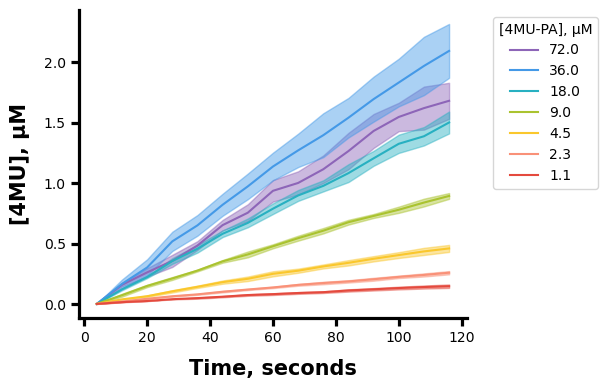

/home/donghyo/projects/ultra_optimized_single_zinc_esterase/design_campaign_ultra1_241122/kinetics_v2.py:418: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticklabels)


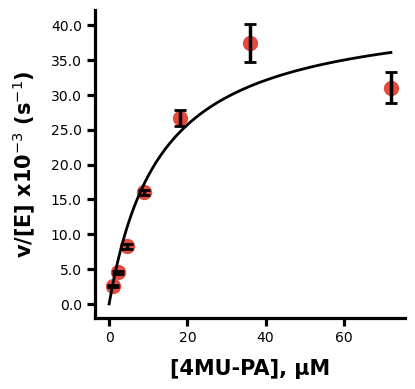

kcat:0.042745±0.003550s⁻¹
Km:13.22±3.10μM
kcat/Km: 3233.26 ± 804.53 M⁻¹ s⁻¹

[SUBST] = 72.0uM, v0 = 3.107438624728761e-08
[SUBST] = 36.0uM, v0 = 3.747976616389618e-08
[SUBST] = 18.0uM, v0 = 2.673208710598222e-08
[SUBST] = 9.0uM, v0 = 1.60056308605917e-08
[SUBST] = 4.5uM, v0 = 8.304542389921605e-09
[SUBST] = 2.3uM, v0 = 4.558436732004448e-09
[SUBST] = 1.1uM, v0 = 2.60984744531448e-09


In [ ]:
### Input/Output File/Directiory ###
excel_file = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase_ULTRAop/single_zinc_esterase/250327_D9_1xZn_kinetics_500nM___phenylacetate_subst_25C_5min_10x_zn_144uMsubstLadder.xlsx'
pics_dir = './pics/'
os.makedirs(pics_dir, exist_ok=True)

### Input Parameter ###
#slope = np.average([9.710399908638067e-10, 9.561887458844373e-10, 9.695313428289856e-10]) # NEW ONE - After removing the last two points
slope = np.average([9.296712951159367e-10, 9.447803716354774e-10, 9.40363467934009e-10]) # NEWEST ONE (250401)

enz_conc = 0.5
rows, cols = list("ABCDEFGH"), [9,10,11,12]
replicate_dic = {9: [10, 11]}
bg_col = 12
sub_concs = np.array([72, 36, 18, 9, 4.5, 2.3, 1.1])              #[144, 72, 36, 18, 9, 4.5, 2.25, 1.125]
col_range_to_analyze = (2, 8)                                     # From 2nd to 8th columns
start_time = 0
end_time = 120
substrate_name = '4MU-PA'

### Parameter Preprocessing ###
transpose_dic = make_transpose_dic(rows, cols)
rename_dic = make_rename_dic(transpose_dic, rows, cols)
represent_row = "A"
replicate_rows = ["ABCDEFGHIJKL"[cols.index(rep)] for rep in list(replicate_dic.values())[0]]
bg_row = "ABCDEFGHIJKL"[cols.index(bg_col)]
row_column_ranges = {represent_row: col_range_to_analyze}
active_wells = make_active_wells(row_column_ranges)

### Data Parsing/Plotting ###
bn = os.path.basename(f'{excel_file}').replace('.xlsx','')
kinetic_data = parse_kinetics(excel_file, active_wells, start_row=48)
kinetic_data.rename(columns=rename_dic, inplace=True)
v0_enz = mm_kinetics(kinetic_data, bn, rows, cols, active_wells, bg_row, enz_conc, sub_concs, substrate_name, pics_dir, replicate_rows, fit_type='straight_line', slope=slope,
            cutoff_start_time=start_time, cutoff_end_time=end_time, plate_type='full', y_ax_mm_intv=0.1, x_ax_mm_intv=50, legend_label=f'[{substrate_name}], μM', norm_zero=True)


### II.III.K. 250327 F12 Kinetics ([E]<sub>0</sub> = 500nM; [Zn(II)] = 5μM; Temp = 25C) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


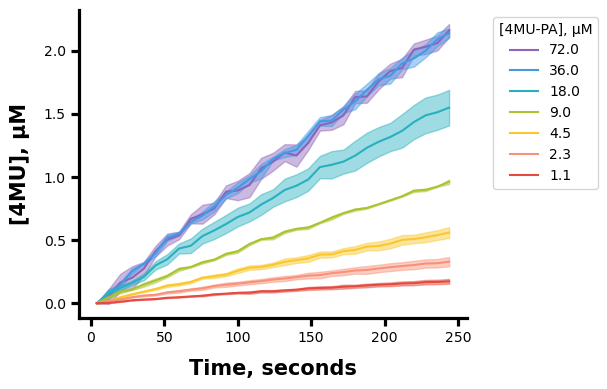

/home/donghyo/projects/ultra_optimized_single_zinc_esterase/design_campaign_ultra1_241122/kinetics_v2.py:418: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticklabels)


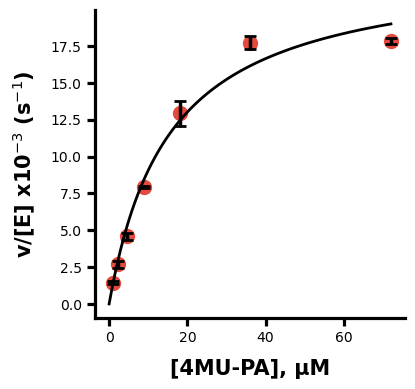

kcat:0.023096±0.001007s⁻¹
Km:15.44±1.82μM
kcat/Km: 1495.75 ± 187.81 M⁻¹ s⁻¹

[SUBST] = 72.0uM, v0 = 1.7838733276332382e-08
[SUBST] = 36.0uM, v0 = 1.7732168814468174e-08
[SUBST] = 18.0uM, v0 = 1.293620052752734e-08
[SUBST] = 9.0uM, v0 = 7.927670819909439e-09
[SUBST] = 4.5uM, v0 = 4.5860236858894136e-09
[SUBST] = 2.3uM, v0 = 2.6850776315578404e-09
[SUBST] = 1.1uM, v0 = 1.4519880848208158e-09


In [ ]:
### Input/Output File/Directiory ###
excel_file = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase_ULTRAop/single_zinc_esterase/250327_F12_1xZn_kinetics_500nM___phenylacetate_subst_25C_5min_10x_zn_144uMsubstLadder.xlsx'
pics_dir = './pics/'
os.makedirs(pics_dir, exist_ok=True)

### Input Parameter ###
#slope = np.average([9.710399908638067e-10, 9.561887458844373e-10, 9.695313428289856e-10]) # NEW ONE - After removing the last two points
slope = np.average([9.296712951159367e-10, 9.447803716354774e-10, 9.40363467934009e-10]) # NEWEST ONE (250401)

enz_conc = 0.5
rows, cols = list("ABCDEFGH"), [9,10,11,12]
replicate_dic = {9: [10, 11]}
bg_col = 12
sub_concs = np.array([72, 36, 18, 9, 4.5, 2.3, 1.1])              #[144, 72, 36, 18, 9, 4.5, 2.25, 1.125]
col_range_to_analyze = (2, 8)                                     # From 2nd to 8th columns
start_time = 0
end_time = 1200
substrate_name = '4MU-PA'

### Parameter Preprocessing ###
transpose_dic = make_transpose_dic(rows, cols)
rename_dic = make_rename_dic(transpose_dic, rows, cols)
represent_row = "A"
replicate_rows = ["ABCDEFGHIJKL"[cols.index(rep)] for rep in list(replicate_dic.values())[0]]
bg_row = "ABCDEFGHIJKL"[cols.index(bg_col)]
row_column_ranges = {represent_row: col_range_to_analyze}
active_wells = make_active_wells(row_column_ranges)

### Data Parsing/Plotting ###
bn = os.path.basename(f'{excel_file}').replace('.xlsx','')
kinetic_data = parse_kinetics(excel_file, active_wells, start_row=48)
kinetic_data.rename(columns=rename_dic, inplace=True)
v0_enz = mm_kinetics(kinetic_data, bn, rows, cols, active_wells, bg_row, enz_conc, sub_concs, substrate_name, pics_dir, replicate_rows, fit_type='straight_line', slope=slope,
            cutoff_start_time=start_time, cutoff_end_time=end_time, plate_type='full', y_ax_mm_intv=0.1, x_ax_mm_intv=50, legend_label=f'[{substrate_name}], μM', norm_zero=True)


### II.III.L. 250327 C7 Kinetics ([E]<sub>0</sub> = 500nM; [Zn(II)] = 5μM; Temp = 25C) (BONUS DATA)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


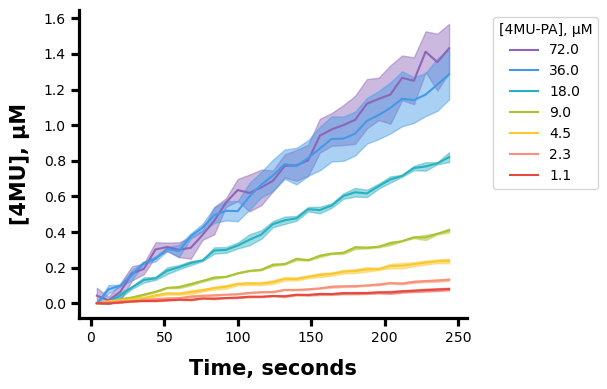

/home/donghyo/projects/ultra_optimized_single_zinc_esterase/design_campaign_ultra1_241122/kinetics_v2.py:418: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticklabels)


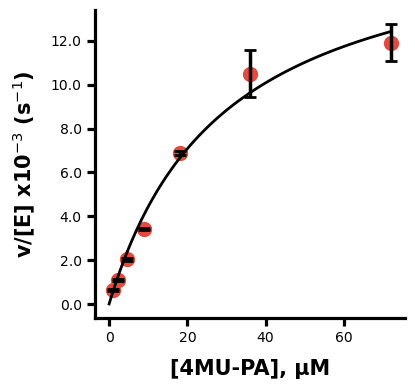

kcat:0.017505±0.001494s⁻¹
Km:29.43±5.56μM
kcat/Km: 594.75 ± 123.31 M⁻¹ s⁻¹

[SUBST] = 72.0uM, v0 = 1.1921347431980872e-08
[SUBST] = 36.0uM, v0 = 1.0502085356454448e-08
[SUBST] = 18.0uM, v0 = 6.876339889340218e-09
[SUBST] = 9.0uM, v0 = 3.4176610149533433e-09
[SUBST] = 4.5uM, v0 = 2.027782986307822e-09
[SUBST] = 2.3uM, v0 = 1.10316287592566e-09
[SUBST] = 1.1uM, v0 = 6.40900112655525e-10


In [ ]:
### Input/Output File/Directiory ###
excel_file = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase_ULTRAop/single_zinc_esterase/250327_C7_1xZn_kinetics_500nM___phenylacetate_subst_25C_5min_10x_zn_144uMsubstLadder.xlsx'
pics_dir = './pics/'
os.makedirs(pics_dir, exist_ok=True)

### Input Parameter ###
#slope = np.average([9.710399908638067e-10, 9.561887458844373e-10, 9.695313428289856e-10]) # NEW ONE - After removing the last two points
slope = np.average([9.296712951159367e-10, 9.447803716354774e-10, 9.40363467934009e-10]) # NEWEST ONE (250401)

enz_conc = 0.5
rows, cols = list("ABCDEFGH"), [9,10,11,12]
replicate_dic = {9: [10, 11]}
bg_col = 12
sub_concs = np.array([72, 36, 18, 9, 4.5, 2.3, 1.1])              #[144, 72, 36, 18, 9, 4.5, 2.25, 1.125]
col_range_to_analyze = (2, 8)                                     # From 2nd to 8th columns
start_time = 0
end_time = 1200
substrate_name = '4MU-PA'

### Parameter Preprocessing ###
transpose_dic = make_transpose_dic(rows, cols)
rename_dic = make_rename_dic(transpose_dic, rows, cols)
represent_row = "A"
replicate_rows = ["ABCDEFGHIJKL"[cols.index(rep)] for rep in list(replicate_dic.values())[0]]
bg_row = "ABCDEFGHIJKL"[cols.index(bg_col)]
row_column_ranges = {represent_row: col_range_to_analyze}
active_wells = make_active_wells(row_column_ranges)

### Data Parsing/Plotting ###
bn = os.path.basename(f'{excel_file}').replace('.xlsx','')
kinetic_data = parse_kinetics(excel_file, active_wells, start_row=48)
kinetic_data.rename(columns=rename_dic, inplace=True)
v0_enz = mm_kinetics(kinetic_data, bn, rows, cols, active_wells, bg_row, enz_conc, sub_concs, substrate_name, pics_dir, replicate_rows, fit_type='straight_line', slope=slope,
            cutoff_start_time=start_time, cutoff_end_time=end_time, plate_type='full', y_ax_mm_intv=0.1, x_ax_mm_intv=50, legend_label=f'[{substrate_name}], μM', norm_zero=True)


### II.III.M. 250327 ZETA_4 (C5) Kinetics ([E]<sub>0</sub> = 500nM; [Zn(II)] = 5μM; Temp = 25C)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


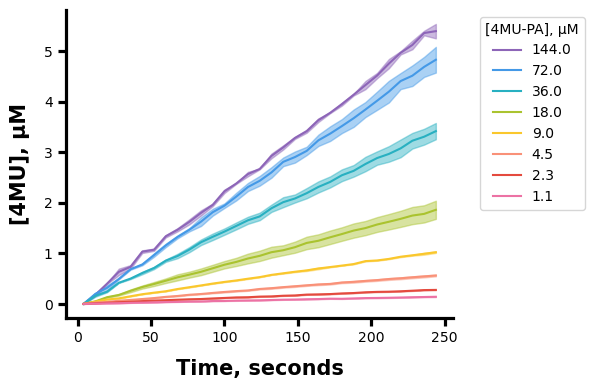

/home/donghyo/projects/ultra_optimized_single_zinc_esterase/design_campaign_ultra1_241122/kinetics_v2.py:421: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticklabels)


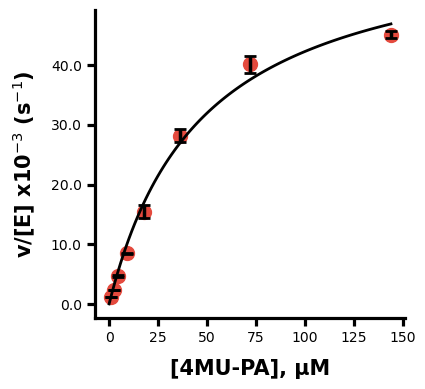

kcat:0.062456±0.002530s⁻¹
Km:47.68±4.57μM
kcat/Km: 1309.81 ± 136.21 M⁻¹ s⁻¹

[SUBST] = 144.0uM, v0/[E] = 4.513837297757966e-08
[SUBST] = 72.0uM, v0/[E] = 4.012167753161181e-08
[SUBST] = 36.0uM, v0/[E] = 2.821388711696869e-08
[SUBST] = 18.0uM, v0/[E] = 1.5482176855610363e-08
[SUBST] = 9.0uM, v0/[E] = 8.455953104819711e-09
[SUBST] = 4.5uM, v0/[E] = 4.670487056698355e-09
[SUBST] = 2.3uM, v0/[E] = 2.2796282293170872e-09
[SUBST] = 1.1uM, v0/[E] = 1.164831540838795e-09


In [ ]:
### Input/Output File/Directiory ###
excel_file = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase_ULTRAop/single_zinc_esterase/250327_C5_1xZn_kinetics_500nM___phenylacetate_subst_25C_5min_10x_zn_144uMsubstLadder.xlsx'
pics_dir = './pics/'
os.makedirs(pics_dir, exist_ok=True)

### Input Parameter ###
#slope = np.average([9.710399908638067e-10, 9.561887458844373e-10, 9.695313428289856e-10]) # NEW ONE - After removing the last two points
slope = np.average([9.296712951159367e-10, 9.447803716354774e-10, 9.40363467934009e-10]) # NEWEST ONE (250401)

enz_conc = 0.5
rows, cols = list("ABCDEFGH"), [1,2,3,4]
replicate_dic = {1: [2, 3]}
bg_col = 4
sub_concs = np.array([144, 72, 36, 18, 9, 4.5, 2.3, 1.1])              #[144, 72, 36, 18, 9, 4.5, 2.25, 1.125]
col_range_to_analyze = (1, 8)                                     # From 2nd to 8th columns
start_time = 0
end_time = 1200
substrate_name = '4MU-PA'

### Parameter Preprocessing ###
transpose_dic = make_transpose_dic(rows, cols)
rename_dic = make_rename_dic(transpose_dic, rows, cols)
represent_row = "A"
replicate_rows = ["ABCDEFGHIJKL"[cols.index(rep)] for rep in list(replicate_dic.values())[0]]
bg_row = "ABCDEFGHIJKL"[cols.index(bg_col)]
row_column_ranges = {represent_row: col_range_to_analyze}
active_wells = make_active_wells(row_column_ranges)

### Data Parsing/Plotting ###
bn = os.path.basename(f'{excel_file}').replace('.xlsx','')
kinetic_data = parse_kinetics(excel_file, active_wells, start_row=48)
kinetic_data.rename(columns=rename_dic, inplace=True)
v0_enz = mm_kinetics(kinetic_data, bn, rows, cols, active_wells, bg_row, enz_conc, sub_concs, substrate_name, pics_dir, replicate_rows, fit_type='straight_line', slope=slope,
            cutoff_start_time=start_time, cutoff_end_time=end_time, plate_type='full', y_ax_mm_intv=0.1, x_ax_mm_intv=50, legend_label=f'[{substrate_name}], μM', norm_zero=True)


## II.IV. Michaelis-Menten Kinetics for ZETA_1 Mutants (Knockouts) with Activity


### II.IV.A. 241008 ZETA_1 (A1; Design Campaign 1) **D67A Mutant** Kinetics ([E]<sub>0</sub> = 100nM; [Zn(II)] = 4μM; Temp = 25C)

findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Fo

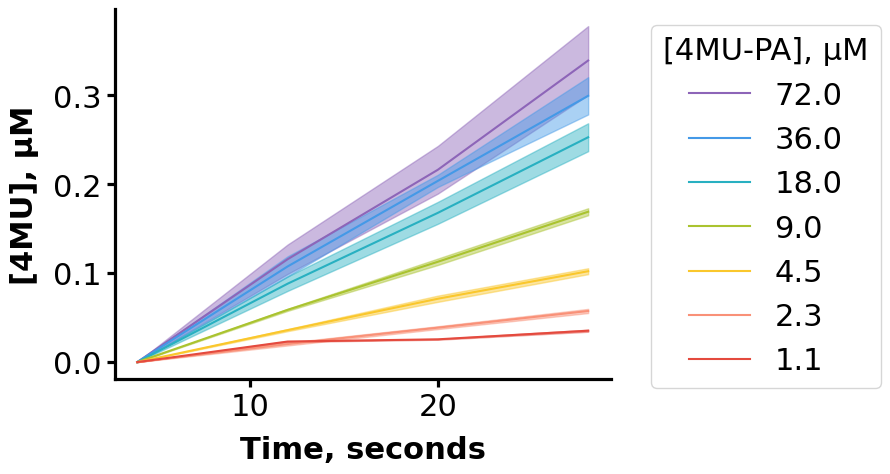

findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family ['Arial Unicode MS'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unic

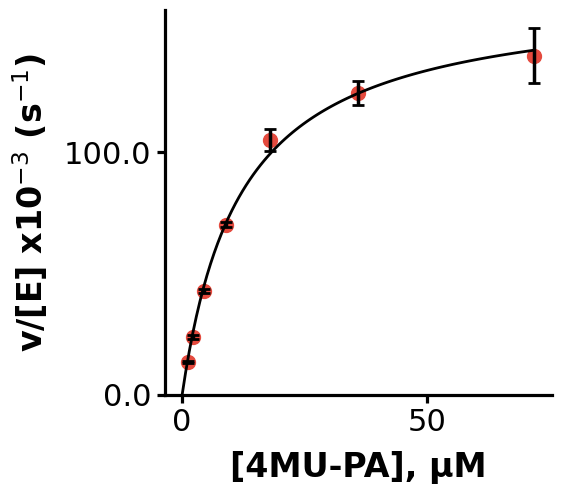

kcat:0.165780±0.006424s⁻¹
Km:12.02±1.35μM
kcat/Km: 13792.67 ± 1640.23 M⁻¹ s⁻¹


[0.13984157967735775,
 0.12439919109123632,
 0.10485186376703198,
 0.07021399974854194,
 0.04276955218535906,
 0.023886833990177686,
 0.013565845162997804]

In [ ]:
# excel file output from neo2
excel_file = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase/paper_data/241008_A1_D67A_FINAL_kinetics_100nM___phenylacetate_subst_25C_5min_40x_zn_144uMsubstLadder.xlsx'

# Standarization slope
#slope = np.average([1.3520814422260207e-09, 1.3922256043348527e-09, 1.396380732487886e-09])
slope = np.average([9.296712951159367e-10, 9.447803716354774e-10, 9.40363467934009e-10]) # NEWEST ONE (250401)

# Time to investigate
start_time = 0
end_time = 30

# What substrate did you use? Important for normalization and for pretty (and accurate) plots.
substrate_name = '4MU-PA'

# - what enzyme concentration did you test? (μΜ) - #
enz_conc = 0.1

# Well information
rows, cols = list("ABCDEFGH"), [9,10,11,12]

# Transpose information
transpose_dic = {"A": 1, 
                 "B": 2,
                 "C": 3,
                 "D": 4,
                 "E": 5,
                 "F": 6,
                 "G": 7,
                 "H": 8,
                 9: "A",
                 10: "B",
                 11: "C",
                 12: "D",
                 }

# make a directory for cute pics
pics_dir = './pics/'
os.makedirs(pics_dir, exist_ok=True)


rename_dic = {}
for key in transpose_dic:
    value = transpose_dic[key]
    if key in rows:
        for col in cols:
            rename_dic[f"{key}{col}"] = f"{transpose_dic[col]}{value}"
    elif key in cols:
        for row in rows:
            rename_dic[f"{row}{key}"] = f"{value}{transpose_dic[row]}"

# specify rows and columns where measurements were taken
row_column_ranges = {
    #'A': (1, 8),
    'A': (2, 8),
}

# rows containing replicates
replicate_rows = ['B', 'C']
#replicate_rows = []

# Create an empty list to store active wells
active_wells = []

# Iterate through rows/columns, append to active wells
for row, (start_col, end_col) in row_column_ranges.items():
    for col in range(start_col, end_col + 1):
        active_wells.append(f"{row}{col}")

# - what substrate concentrations did you test in those specific wells? (μM) - #
#sub_concs = np.array([144, 72, 36, 18, 9, 4.5, 2.25, 1.125])
sub_concs = np.array([72, 36, 18, 9, 4.5, 2.3, 1.1])

# which row is background?
bg_row = 'D'

# plotting stuff
bn = os.path.basename(f'{excel_file}').replace('.xlsx','')
kinetic_data = kinetics.parse_kinetics(excel_file, active_wells, start_row=48)
kinetic_data.rename(columns=rename_dic, inplace=True)
kinetics.mm_kinetics(kinetic_data, bn, active_wells, bg_row, replicate_rows, enz_conc, sub_concs, substrate_name, pics_dir, fit_type='straight_line', slope=slope,
            cutoff_start_time=start_time, cutoff_end_time=end_time, plate_type='full', y_ax_mm_intv=0.1, x_ax_mm_intv=50, legend_label=f'[{substrate_name}], μM', norm_zero=True)

### II.IV.B. 240927 ZETA_1 (A1; Design Campaign 1) **N17A Mutant** Kinetics ([E]<sub>0</sub> = 500nM; [Zn(II)] = 20μM; Temp = 25C)

findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Fo

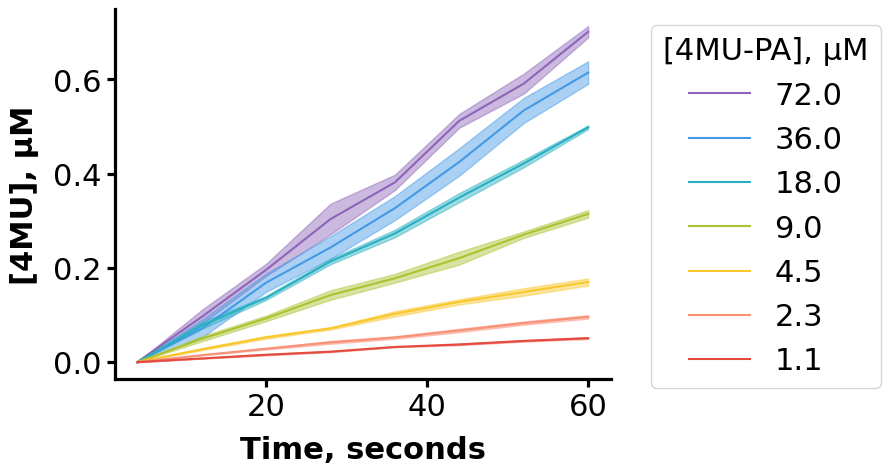

findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Fo

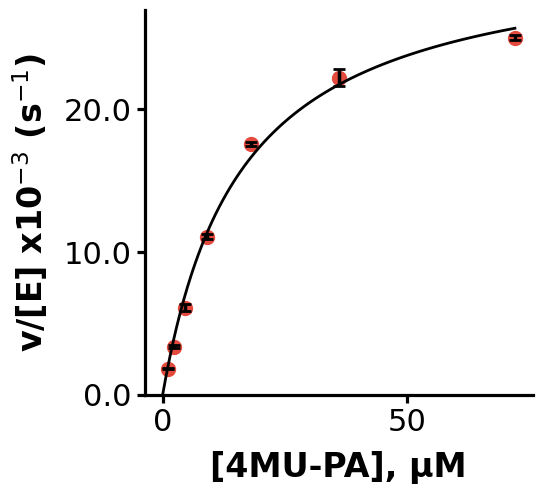

kcat:0.031400±0.000734s⁻¹
Km:16.01±1.00μM
kcat/Km: 1961.07 ± 130.86 M⁻¹ s⁻¹


[0.025033610526531008,
 0.022234619418727078,
 0.01758421716578781,
 0.011093573669041295,
 0.006120175102697305,
 0.0033919267033047894,
 0.0018411720689179123]

In [ ]:
# excel file output from neo2
excel_file = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase/paper_data/240927_A1_N17A_FINAL_kinetics_500nM___phenylacetate_subst_25C_5min_40x_zn_144uMsubstLadder.xlsx'

# Standarization slope
#slope = np.average([1.3520814422260207e-09, 1.3922256043348527e-09, 1.396380732487886e-09])
slope = np.average([9.296712951159367e-10, 9.447803716354774e-10, 9.40363467934009e-10]) # NEWEST ONE (250401)

# Time to investigate
start_time = 0
end_time = 60

# What substrate did you use? Important for normalization and for pretty (and accurate) plots.
substrate_name = '4MU-PA'

# - what enzyme concentration did you test? (μΜ) - #
enz_conc = 0.5

# Well information
rows, cols = list("ABCDEFGH"), [5,6,7,8]

# Transpose information
transpose_dic = {"A": 1, 
                 "B": 2,
                 "C": 3,
                 "D": 4,
                 "E": 5,
                 "F": 6,
                 "G": 7,
                 "H": 8,
                 5: "A",
                 6: "B",
                 7: "C",
                 8: "D",
                 }

# make a directory for cute pics
pics_dir = './pics/'
os.makedirs(pics_dir, exist_ok=True)


rename_dic = {}
for key in transpose_dic:
    value = transpose_dic[key]
    if key in rows:
        for col in cols:
            rename_dic[f"{key}{col}"] = f"{transpose_dic[col]}{value}"
    elif key in cols:
        for row in rows:
            rename_dic[f"{row}{key}"] = f"{value}{transpose_dic[row]}"

# specify rows and columns where measurements were taken
row_column_ranges = {
    #'A': (1, 8),
    'A': (2, 8),
}

# rows containing replicates
replicate_rows = ['B', 'C']
#replicate_rows = []

# Create an empty list to store active wells
active_wells = []

# Iterate through rows/columns, append to active wells
for row, (start_col, end_col) in row_column_ranges.items():
    for col in range(start_col, end_col + 1):
        active_wells.append(f"{row}{col}")

# - what substrate concentrations did you test in those specific wells? (μM) - #
#sub_concs = np.array([144, 72, 36, 18, 9, 4.5, 2.25, 1.125])
sub_concs = np.array([72, 36, 18, 9, 4.5, 2.3, 1.1])

# which row is background?
bg_row = 'D'

# plotting stuff
bn = os.path.basename(f'{excel_file}').replace('.xlsx','')
kinetic_data = kinetics.parse_kinetics(excel_file, active_wells, start_row=48)
kinetic_data.rename(columns=rename_dic, inplace=True)
kinetics.mm_kinetics(kinetic_data, bn, active_wells, bg_row, replicate_rows, enz_conc, sub_concs, substrate_name, pics_dir, fit_type='straight_line', slope=slope,
            cutoff_start_time=start_time, cutoff_end_time=end_time, plate_type='full', y_ax_mm_intv=0.01, x_ax_mm_intv=50, legend_label=f'[{substrate_name}], μM', norm_zero=True)

### II.IV.C. 240927 ZETA_1 (A1; Design Campaign 1) **H130A Mutant** Kinetics ([E]<sub>0</sub> = 500nM; [Zn(II)] = 20μM; Temp = 25C)

findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Fo

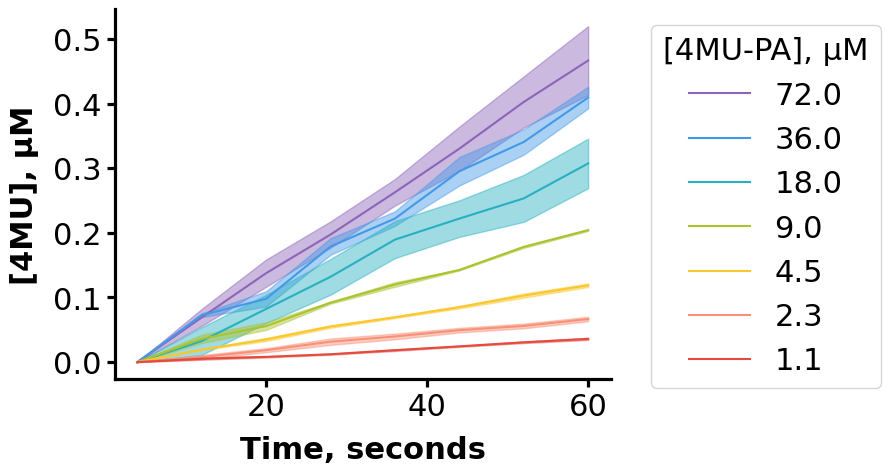

findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family ['Arial Unicode MS'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'Arial Unic

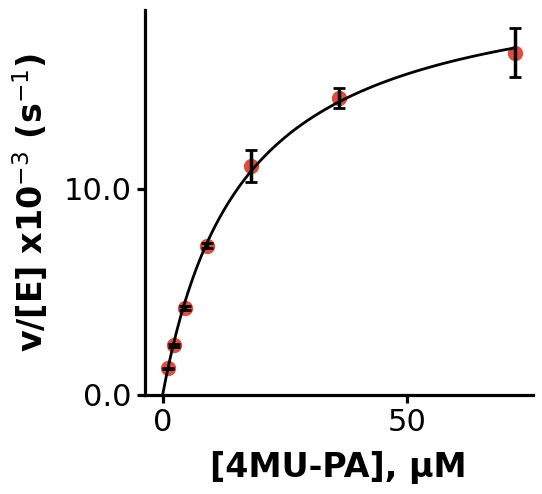

kcat:0.020640±0.000862s⁻¹
Km:16.33±1.81μM
kcat/Km: 1264.19 ± 149.88 M⁻¹ s⁻¹


[0.01659754254847082,
 0.014408241888159938,
 0.011110328521033467,
 0.007232511109955601,
 0.004208260325367988,
 0.0024052520859878085,
 0.0012901236033974854]

In [ ]:
# excel file output from neo2
excel_file = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase/paper_data/240927_A1_H130A_FINAL_kinetics_500nM___phenylacetate_subst_25C_5min_40x_zn_144uMsubstLadder.xlsx'

# Standarization slope
slope = np.average([1.3520814422260207e-09, 1.3922256043348527e-09, 1.396380732487886e-09])
slope = np.average([9.296712951159367e-10, 9.447803716354774e-10, 9.40363467934009e-10]) # NEWEST ONE (250401)

# Time to investigate
start_time = 0
end_time = 60

# What substrate did you use? Important for normalization and for pretty (and accurate) plots.
substrate_name = '4MU-PA'

# - what enzyme concentration did you test? (μΜ) - #
enz_conc = 0.5

# Well information
rows, cols = list("ABCDEFGH"), [5,6,7,8]

# Transpose information
transpose_dic = {"A": 1, 
                 "B": 2,
                 "C": 3,
                 "D": 4,
                 "E": 5,
                 "F": 6,
                 "G": 7,
                 "H": 8,
                 5: "A",
                 6: "B",
                 7: "C",
                 8: "D",
                 }

# make a directory for cute pics
pics_dir = './pics/'
os.makedirs(pics_dir, exist_ok=True)


rename_dic = {}
for key in transpose_dic:
    value = transpose_dic[key]
    if key in rows:
        for col in cols:
            rename_dic[f"{key}{col}"] = f"{transpose_dic[col]}{value}"
    elif key in cols:
        for row in rows:
            rename_dic[f"{row}{key}"] = f"{value}{transpose_dic[row]}"

# specify rows and columns where measurements were taken
row_column_ranges = {
    #'A': (1, 8),
    'A': (2, 8),
}

# rows containing replicates
replicate_rows = ['B', 'C']
#replicate_rows = []

# Create an empty list to store active wells
active_wells = []

# Iterate through rows/columns, append to active wells
for row, (start_col, end_col) in row_column_ranges.items():
    for col in range(start_col, end_col + 1):
        active_wells.append(f"{row}{col}")

# - what substrate concentrations did you test in those specific wells? (μM) - #
#sub_concs = np.array([144, 72, 36, 18, 9, 4.5, 2.25, 1.125])
sub_concs = np.array([72, 36, 18, 9, 4.5, 2.3, 1.1])

# which row is background?
bg_row = 'D'

# plotting stuff
bn = os.path.basename(f'{excel_file}').replace('.xlsx','')
kinetic_data = kinetics.parse_kinetics(excel_file, active_wells, start_row=48)
kinetic_data.rename(columns=rename_dic, inplace=True)
kinetics.mm_kinetics(kinetic_data, bn, active_wells, bg_row, replicate_rows, enz_conc, sub_concs, substrate_name, pics_dir, fit_type='straight_line', slope=slope,
            cutoff_start_time=start_time, cutoff_end_time=end_time, plate_type='full', y_ax_mm_intv=0.01, x_ax_mm_intv=50, legend_label=f'[{substrate_name}], μM', norm_zero=True)

## II.V. Add pH data?


# **III. Zn(II)-DEPENDENCE DATA** 

## III.I. Zn(II)-Dependent Activity Screening of ZETA_1 

### III.I.A. Reaction Progress Curves for 1.) Zn(II)-Free Enzyme, Followed by 2.) Readdition of Zn(II) to Reactions

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


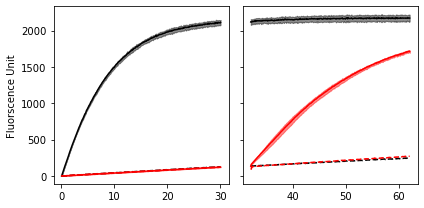

In [ ]:
# excel file output from neo2
excel_file1 = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase/paper_data/240904_zn_chelation_72uM_18uM_1pt8uM_4mu_PositiveTopRow_ChelatedBottomRow_30min_25C_pt1_BEFORE_100uM_zn.xlsx'
excel_file2 = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase/paper_data/240904_zn_chelation_72uM_18uM_1pt8uM_4mu_PositiveTopRow_ChelatedBottomRow_30min_25C_pt1_AFTER_100uM_zn_2min_delay.xlsx'

# Specify row and column ranges
row_column_ranges = {
    'A': (1, 12),
    'B': (1, 12),
}

# Specify replicates
replicate_dic = {
    #1: [2, 3],
    #5: [6, 7],
    9: [10, 11],
}

# Specify background
#background_col = 4
#background_col = 8
background_col = 12

# Create an empty list to store active wells
active_wells = []

# Iterate through rows/columns, append to active wells
for row, (start_col, end_col) in row_column_ranges.items():
    for col in range(start_col, end_col + 1):
        active_wells.append(f"{row}{col}")

# Specify standarization slope
slope = np.average([1.3508627070567126e-09, 1.3772695498339654e-09, 1.3775700821040584e-09, 1.3765183640056685e-09, 1.394227934509494e-09, 1.3708099778611521e-09])

# Load data
screening_data_before_zn = kinetics.parse_kinetics(excel_file1, active_wells, start_row=48)
screening_data_after_zn = kinetics.parse_kinetics(excel_file2, active_wells, start_row=48)

# Standardize
"""
for i, df in enumerate([screening_data_before_zn, screening_data_after_zn]):
    for well in active_wells:
        fu = df[well].values
        product_concentration = fu * slope * 1000000
        df[well] = product_concentration
"""

# Zero-ing        
for well in active_wells:
    screening_data_after_zn[well] = screening_data_after_zn[well] - np.min(screening_data_before_zn[well])
    screening_data_before_zn[well] = screening_data_before_zn[well] - np.min(screening_data_before_zn[well])
    
# Convernting time
for i, df in enumerate([screening_data_before_zn, screening_data_after_zn]):
    df["Time"] = df["Time"]/60
screening_data_after_zn["Time"] = screening_data_after_zn["Time"] + 32

fig, axes = plt.subplots(1, 2, figsize=(6,3))
for representive_col in replicate_dic:
    replicates = [representive_col]
    replicates.extend(replicate_dic[representive_col])
    
    for row, name, color in zip(["A", "B"], ["WT", "Chelated"], ["black", "red"]):
        replicates_well = [f"{row}{col}" for col in replicates]
        avg_product_concentration_before_zn = np.array(screening_data_before_zn[replicates_well].mean(axis=1).tolist())
        std_product_concentration_before_zn = np.array(screening_data_before_zn[replicates_well].std(axis=1).tolist())
        
        axes[0].plot(screening_data_before_zn["Time"].values, avg_product_concentration_before_zn, color=color)
        axes[0].fill_between(screening_data_before_zn["Time"].values, 
                             avg_product_concentration_before_zn - std_product_concentration_before_zn,
                             avg_product_concentration_before_zn + std_product_concentration_before_zn,
                             color=color, alpha = 0.45)
        
        avg_product_concentration_after_zn = np.array(screening_data_after_zn[replicates_well].mean(axis=1).tolist())
        std_product_concentration_after_zn = np.array(screening_data_after_zn[replicates_well].std(axis=1).tolist())
        
        axes[1].plot(screening_data_after_zn["Time"].values, avg_product_concentration_after_zn, color=color)
        axes[1].fill_between(screening_data_after_zn["Time"].values, 
                             avg_product_concentration_after_zn - std_product_concentration_after_zn,
                             avg_product_concentration_after_zn + std_product_concentration_after_zn,
                             color=color, alpha = 0.45)
        
        axes[0].plot(screening_data_before_zn["Time"].values, screening_data_before_zn[f"{row}{background_col}"], color=color, linestyle='dashed')
        axes[1].plot(screening_data_after_zn["Time"].values, screening_data_after_zn[f"{row}{background_col}"], color=color, linestyle='dashed')
    
    axes[0].set_ylim(axes[0].get_ylim()[0], axes[1].get_ylim()[1])
    axes[1].set_ylim(axes[0].get_ylim()[0], axes[1].get_ylim()[1])
    axes[1].set_yticklabels([])

    #axes[0].set_ylabel("[4MU] (uM)")
    axes[0].set_ylabel("Fluorscence Unit")
plt.tight_layout()
plt.savefig("/home/donghyo/projects/zinc_hydrolase/enzyme_design/20240405_design_campaign1/cute_pics/" + 
            "zinc_chelating_progress_curves_1pt8uM_4MUPA.eps", 
            format='eps')
plt.show()

## III.II. Dissociation Constant (K<sub>d</sub>) Measurement for Zn(II) Binding to ZETA_1 + Mutants (Knockouts)

### III.II.A. Load Data and Plot (Non-Normalized)

In [ ]:
file_path = '/home/donghyo/projects/zinc_hydrolase/enzyme_design/20240405_design_campaign1/exp_data/zinc_affinity/Zn-Hydrolase_binding_data.csv'
data = pd.read_csv(file_path, delimiter=',', dtype=float, na_values=['', ' '])

/usr/lib/python3/dist-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  ret

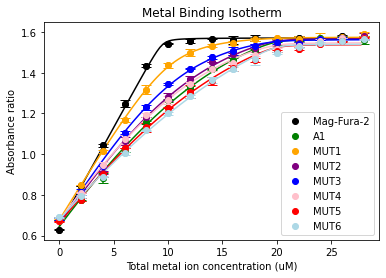

In [ ]:
#Plot not normalized data

#Dye (Mag-Fura-2)
plt.plot(data.iloc[:, 0], data.iloc[:, 1], color='black')
plt.scatter(data.iloc[:, 2], data.iloc[:, 3], color='black', label='Mag-Fura-2')
plt.errorbar(data.iloc[:, 2], data.iloc[:, 3], yerr=data.iloc[:, 4], fmt='o', capsize=5, color='black')

#A1
plt.plot(data.iloc[:, 5], data.iloc[:, 6], color='green')
plt.scatter(data.iloc[:, 7], data.iloc[:, 8], color='green', label='A1')
plt.errorbar(data.iloc[:, 7], data.iloc[:, 8], yerr=data.iloc[:, 9], fmt='o', capsize=5, color='green')

#MUT1
plt.plot(data.iloc[:, 10], data.iloc[:, 11], color='orange')
plt.scatter(data.iloc[:, 12], data.iloc[:, 13], color='orange', label='MUT1')
plt.errorbar(data.iloc[:, 12], data.iloc[:, 13], yerr=data.iloc[:, 14], fmt='o', capsize=5, color='orange')

#MUT2
plt.plot(data.iloc[:, 15], data.iloc[:, 16], color='purple')
plt.scatter(data.iloc[:, 17], data.iloc[:, 18], color='purple', label='MUT2')
plt.errorbar(data.iloc[:, 17], data.iloc[:, 18], yerr=data.iloc[:, 19], fmt='o', capsize=5, color='purple')

#MUT3
plt.plot(data.iloc[:, 20], data.iloc[:, 21], color='blue')
plt.scatter(data.iloc[:, 22], data.iloc[:, 23], color='blue', label='MUT3')
plt.errorbar(data.iloc[:, 22], data.iloc[:, 23], yerr=data.iloc[:, 24], fmt='o', capsize=5, color='blue')

#MUT4
plt.plot(data.iloc[:, 25], data.iloc[:, 26], color='pink')
plt.scatter(data.iloc[:, 27], data.iloc[:, 28], color='pink', label='MUT4')
plt.errorbar(data.iloc[:, 27], data.iloc[:, 28], yerr=data.iloc[:, 29], fmt='o', capsize=5, color='pink')

#MUT5
plt.plot(data.iloc[:, 30], data.iloc[:, 31], color='red')
plt.scatter(data.iloc[:, 32], data.iloc[:, 33], color='red', label='MUT5')
plt.errorbar(data.iloc[:, 32], data.iloc[:, 33], yerr=data.iloc[:, 34], fmt='o', capsize=5, color='red')

#MUT6
plt.plot(data.iloc[:, 35], data.iloc[:, 36], color='lightblue')
plt.scatter(data.iloc[:, 37], data.iloc[:, 38], color='lightblue', label='MUT6')
plt.errorbar(data.iloc[:, 37], data.iloc[:, 38], yerr=data.iloc[:, 39], fmt='o', capsize=5, color='lightblue')

plt.xlabel('Total metal ion concentration (uM)')
plt.ylabel('Absorbance ratio')
plt.title('Metal Binding Isotherm')
plt.legend()
plt.show()

### III.II.B. Normalize Data and Plot

In [ ]:
#Data normalization

#Dye
dye_fit_normalized = data.iloc[:, 1] / np.max(np.abs(data.iloc[:, 1]))
dye_data_normalized = data.iloc[:, 3] / np.max(np.abs(data.iloc[:, 1]))
dye_error_normalized = data.iloc[:, 4] / np.max(np.abs(data.iloc[:, 1]))

#A1
A1_fit_normalized = data.iloc[:, 6] / np.max(np.abs(data.iloc[:, 6]))
A1_data_normalized = data.iloc[:, 8] / np.max(np.abs(data.iloc[:, 6]))
A1_error_normalized = data.iloc[:, 9] / np.max(np.abs(data.iloc[:, 6]))

#MUT1
MUT1_fit_normalized = data.iloc[:, 11] / np.max(np.abs(data.iloc[:, 11]))
MUT1_data_normalized = data.iloc[:, 13] / np.max(np.abs(data.iloc[:, 11]))
MUT1_error_normalized = data.iloc[:, 14] / np.max(np.abs(data.iloc[:, 11]))

#MUT2
MUT2_fit_normalized = data.iloc[:, 16] / np.max(np.abs(data.iloc[:, 16]))
MUT2_data_normalized = data.iloc[:, 18] / np.max(np.abs(data.iloc[:, 16]))
MUT2_error_normalized = data.iloc[:, 19] / np.max(np.abs(data.iloc[:, 16]))

#MUT3
MUT3_fit_normalized = data.iloc[:, 21] / np.max(np.abs(data.iloc[:, 21]))
MUT3_data_normalized = data.iloc[:, 23] / np.max(np.abs(data.iloc[:, 21]))
MUT3_error_normalized = data.iloc[:, 24] / np.max(np.abs(data.iloc[:, 21]))

#MUT4
MUT4_fit_normalized = data.iloc[:, 26] / np.max(np.abs(data.iloc[:, 26]))
MUT4_data_normalized = data.iloc[:, 28] / np.max(np.abs(data.iloc[:, 26]))
MUT4_error_normalized = data.iloc[:, 29] / np.max(np.abs(data.iloc[:, 26]))

#MUT5
MUT5_fit_normalized = data.iloc[:, 31] / np.max(np.abs(data.iloc[:, 31]))
MUT5_data_normalized = data.iloc[:, 33] / np.max(np.abs(data.iloc[:, 31]))
MUT5_error_normalized = data.iloc[:, 34] / np.max(np.abs(data.iloc[:, 31]))

#MUT6
MUT6_fit_normalized = data.iloc[:, 36] / np.max(np.abs(data.iloc[:, 36]))
MUT6_data_normalized = data.iloc[:, 38] / np.max(np.abs(data.iloc[:, 36]))
MUT6_error_normalized = data.iloc[:, 39] / np.max(np.abs(data.iloc[:, 36]))

/usr/lib/python3/dist-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  ret

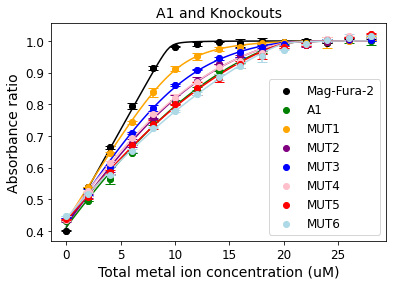

In [ ]:
#Plot normalized data

#Dye (Mag-Fura-2)
plt.plot(data.iloc[:, 0], dye_fit_normalized, color='black')
plt.scatter(data.iloc[:, 2], dye_data_normalized, color='black', label='Mag-Fura-2')
plt.errorbar(data.iloc[:, 2], dye_data_normalized, yerr = dye_error_normalized, fmt='o', capsize=5, color='black')

#A1
plt.plot(data.iloc[:, 5], A1_fit_normalized, color='green')
plt.scatter(data.iloc[:, 7], A1_data_normalized, color='green', label='A1')
plt.errorbar(data.iloc[:, 7], A1_data_normalized, yerr = A1_error_normalized, fmt='o', capsize=5, color='green')

#MUT1
plt.plot(data.iloc[:, 10], MUT1_fit_normalized, color='orange')
plt.scatter(data.iloc[:, 12], MUT1_data_normalized, color='orange', label='MUT1')
plt.errorbar(data.iloc[:, 12], MUT1_data_normalized, yerr = MUT1_error_normalized, fmt='o', capsize=5, color='orange')

#MUT2
plt.plot(data.iloc[:, 15], MUT2_fit_normalized, color='purple')
plt.scatter(data.iloc[:, 17], MUT2_data_normalized, color='purple', label='MUT2')
plt.errorbar(data.iloc[:, 17], MUT2_data_normalized, yerr = MUT2_error_normalized, fmt='o', capsize=5, color='purple')

#MUT3
plt.plot(data.iloc[:, 20], MUT3_fit_normalized, color='blue')
plt.scatter(data.iloc[:, 22], MUT3_data_normalized, color='blue', label='MUT3')
plt.errorbar(data.iloc[:, 22], MUT3_data_normalized, yerr = MUT3_error_normalized, fmt='o', capsize=5, color='blue')

#MUT4
plt.plot(data.iloc[:, 25], MUT4_fit_normalized, color='pink')
plt.scatter(data.iloc[:, 27], MUT4_data_normalized, color='pink', label='MUT4')
plt.errorbar(data.iloc[:, 27], MUT4_data_normalized, yerr = MUT4_error_normalized, fmt='o', capsize=5, color='pink')

#MUT5
plt.plot(data.iloc[:, 30], MUT5_fit_normalized, color='red')
plt.scatter(data.iloc[:, 32], MUT5_data_normalized, color='red', label='MUT5')
plt.errorbar(data.iloc[:, 32], MUT5_data_normalized, yerr = MUT5_error_normalized, fmt='o', capsize=5, color='red')

#MUT6
plt.plot(data.iloc[:, 35], MUT6_fit_normalized, color='lightblue')
plt.scatter(data.iloc[:, 37], MUT6_data_normalized, color='lightblue', label='MUT6')
plt.errorbar(data.iloc[:, 37], MUT6_data_normalized, yerr = MUT6_error_normalized, fmt='o', capsize=5, color='lightblue')

plt.xlabel('Total metal ion concentration (uM)', fontsize=14)
plt.ylabel('Absorbance ratio', fontsize=14)
plt.title('A1 and Knockouts', fontsize=14)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.savefig("./pics/zinc_affinity_absorbance_ratio_plot.svg")
plt.show()

# **IV. TOTAL CATALYTIC TURNOVER DATA** 

## IV.I. Total Turnover Experiment for ZETA_1

### IV.I.A. Progress Curves for the Total Turnover Experiment (Enzyme-Catalyzed, Background, & 4MU Product Standards)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


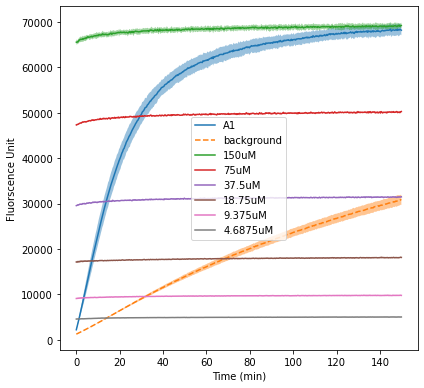

In [ ]:
# excel file output from neo2
excel_file = '/net/expdata/Users/Baker_Lab/woodbuse/neo2_platereader/zinc_hydrolase/paper_data/241008_a1_turnover_100nM_enz_AND_150uM_4muPA_40x_ZINC_blank2ndROW_ladder150uMdown.xlsx'

# Specify row and column ranges
row_column_ranges = {
    'A': (5, 7),
    'B': (5, 7),
    'C': (5, 7),
    'D': (5, 7),
    'E': (5, 7),
    'F': (5, 7),
    'G': (5, 7),
    'H': (5, 7),
}

enzyme_row = "A"

# Specify replicates
replicate_dic = {
    5: [6, 7]
}

# Specify background
background_row = "B"

# Specify standard wells
standard_wells = [["150uM", ["C5", "C6", "C7"]], ["75uM", ["D5", "D6", "D7"]], ["37.5uM", ["E5", "E6", "E7"]], ["18.75uM", ["F5", "F6", "F7"]], ["9.375uM", ["G5", "G6", "G7"]], ["4.6875uM", ["H5", "H6", "H7"]]]

# Specify time ranges to show
max_time = 150 # minutes

# Create an empty list to store active wells
active_wells = []

# Iterate through rows/columns, append to active wells
for row, (start_col, end_col) in row_column_ranges.items():
    for col in range(start_col, end_col + 1):
        active_wells.append(f"{row}{col}")

# Load data
screening_data = kinetics.parse_kinetics(excel_file, active_wells, start_row=48)

# Convernting time
screening_data["Time"] = screening_data["Time"]/60
screening_data = screening_data[screening_data["Time"] < max_time]

plt.figure(figsize=(6, 5.5))

for representive_col in replicate_dic:
    replicates = [representive_col]
    replicates.extend(replicate_dic[representive_col])

    
    replicates_well = [f"{enzyme_row}{col}" for col in replicates]
    avg_product_concentration = np.array(screening_data[replicates_well].mean(axis=1).tolist())
    std_product_concentration = np.array(screening_data[replicates_well].std(axis=1).tolist())
    plt.plot(screening_data["Time"].values, avg_product_concentration, label="A1")
    plt.fill_between(screening_data["Time"].values, 
                         avg_product_concentration - std_product_concentration,
                         avg_product_concentration + std_product_concentration,
                         alpha = 0.45)

    replicates_well = [f"{background_row}{col}" for col in replicates]
    avg_product_concentration = np.array(screening_data[replicates_well].mean(axis=1).tolist())
    std_product_concentration = np.array(screening_data[replicates_well].std(axis=1).tolist())
    plt.plot(screening_data["Time"].values, avg_product_concentration, linestyle='dashed', label="background")
    plt.fill_between(screening_data["Time"].values, 
                         avg_product_concentration - std_product_concentration,
                         avg_product_concentration + std_product_concentration,
                         alpha = 0.45)
    
    for product_label, replicates_well in standard_wells:
        avg_product_concentration = np.array(screening_data[replicates_well].mean(axis=1).tolist())
        std_product_concentration = np.array(screening_data[replicates_well].std(axis=1).tolist())
        plt.plot(screening_data["Time"].values, avg_product_concentration, label=product_label)
        plt.fill_between(screening_data["Time"].values, 
                             avg_product_concentration - std_product_concentration,
                             avg_product_concentration + std_product_concentration,
                             alpha = 0.45)
    
    plt.ylabel("Fluorscence Unit")
    plt.xlabel("Time (min)")

plt.legend()
plt.tight_layout()
plt.savefig("/home/donghyo/projects/zinc_hydrolase/enzyme_design/20240405_design_campaign1/cute_pics/" + 
            "241009_A1_turnover_experiment.eps", 
            format='eps')
plt.show()

### IV.I.B. Product Fluorescence Standard Curve

Pearson R-square: (0.9753361485484224, 4.104272098434487e-66)


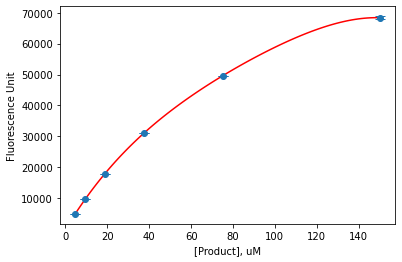

In [ ]:
from scipy.stats import pearsonr

calibration_x = []
calibration_y = []
calibration_y_std = []

enzyme_concentration = 0.1 # uM

standard_wells = [["150uM", ["C5", "C6", "C7"]], ["75uM", ["D5", "D6", "D7"]], ["37.5uM", ["E5", "E6", "E7"]], ["18.75uM", ["F5", "F6", "F7"]], ["9.375uM", ["G5", "G6", "G7"]], ["4.6875uM", ["H5", "H6", "H7"]]]
for product_concentration, well_list in standard_wells:
    #calibration_y.append(float(product_concentration[:-2])/enzyme_concentration)
    calibration_x.append(float(product_concentration[:-2]))
    #calibration_y.append(float(product_concentration[:-2]))
    calibration_y.append(np.mean(np.array(screening_data[well_list].mean(axis=0).tolist())))
    calibration_y_std.append(np.std(np.array(screening_data[well_list].mean(axis=0).tolist())))
    #calibration_x.append(np.mean(np.array(screening_data[well_list].mean(axis=0).tolist())))
    
plt.errorbar(calibration_x, calibration_y, yerr=calibration_y_std, fmt="o", capsize=5)


#coefficients = np.polyfit(calibration_x, calibration_y, 1)
#print ("Coefficients:", coefficients)
#poly = np.poly1d(coefficients)
"""
x_fit = np.linspace(min(calibration_x), max(calibration_x), 100)
y_fit = poly(x_fit)
plt.plot(y_fit, x_fit, color='red', label='Fitted Line')
"""
coefficients = np.polyfit(calibration_x, calibration_y, 4)
poly = np.poly1d(coefficients)
x_fit = np.linspace(min(calibration_x), max(calibration_x), 100)
y_fit = poly(x_fit)
plt.plot(x_fit, y_fit, color='red', label='Fitted Line')

print ("Pearson R-square:", pearsonr(x_fit, y_fit))
plt.ylabel("Fluorescence Unit")
#plt.ylabel("Turnover Number")
plt.xlabel("[Product], uM")
plt.savefig("/home/donghyo/projects/zinc_hydrolase/enzyme_design/20240405_design_campaign1/cute_pics/" + 
            "241009_calibration_curve_for_turnover_number_experiment.eps", 
            format='eps')
plt.show()

### IV.I.C. Turnover Number Plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


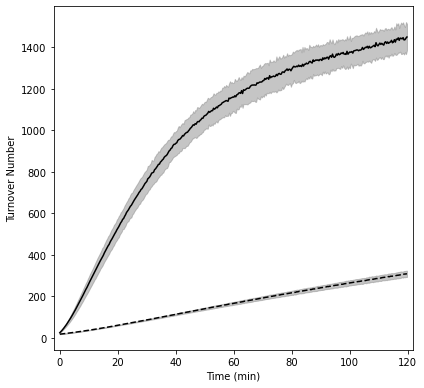

In [ ]:
enzyme_concentration = 0.1 # uM

converted_screening_data = pd.DataFrame()
converted_screening_data["Time"] = screening_data["Time"]
for well in active_wells:
    converted_screening_data[well] = poly(screening_data[well].to_list()) / enzyme_concentration
converted_screening_data = converted_screening_data[converted_screening_data["Time"] < 120]
    
plt.figure(figsize=(6, 5.5))

for representive_col in replicate_dic:
    replicates = [representive_col]
    replicates.extend(replicate_dic[representive_col])

    
    replicates_well = [f"{enzyme_row}{col}" for col in replicates]
    bg_replicates_well = [f"{background_row}{col}" for col in replicates]
    
    avg_product_concentration = np.array(converted_screening_data[replicates_well].mean(axis=1).tolist())
    std_product_concentration = np.array(converted_screening_data[replicates_well].std(axis=1).tolist())
    plt.plot(converted_screening_data["Time"].values, avg_product_concentration, label="A1", color="black")
    plt.fill_between(converted_screening_data["Time"].values, 
                         avg_product_concentration - std_product_concentration,
                         avg_product_concentration + std_product_concentration,
                         alpha = 0.45, color="gray")

    avg_product_concentration = np.array(converted_screening_data[bg_replicates_well].mean(axis=1).tolist())
    std_product_concentration = np.array(converted_screening_data[bg_replicates_well].std(axis=1).tolist())
    plt.plot(converted_screening_data["Time"].values, avg_product_concentration, linestyle='dashed', label="background", color="black")
    plt.fill_between(converted_screening_data["Time"].values, 
                         avg_product_concentration - std_product_concentration,
                         avg_product_concentration + std_product_concentration,
                         alpha = 0.45, color="gray")
    
    #plt.ylabel("[Product]")
    plt.ylabel("Turnover Number")
    plt.xlabel("Time (min)")

plt.xlim(-2, 122)
#plt.ylim(-20, 1400)
plt.tight_layout()
plt.savefig("/home/donghyo/projects/zinc_hydrolase/enzyme_design/20240405_design_campaign1/cute_pics/" + 
            "241009_A1_turnover_experiment_y_axis_turnover_not_zeroing.eps", 
            format='eps')
plt.show()

# **V. BIOPHYSICAL CHARACTERIZATION DATA** 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def smooth_dataframe(df, window_size):
    df['deg'] = df['deg'].rolling(window=window_size, center=True, min_periods=1).mean()
    df['MRE'] = df['MRE'].rolling(window=window_size, center=True, min_periods=1).mean()
    return df

def plot_CD_spectrum_temperature_interval(file_path, protein_concentration, protein_length, pathlength= 1, wavelength_min=190, window_size=1, colors=None, save=None):
    f = open(file_path)
    data = f.read()
    f.close()
    
    data = data.split("Channel 1\n")[1].split("Channel 2\n")[0].strip()
    data = [el.split(",") for el in data.split("\n")]
    cols = ["Wavelength"]
    cols.extend(data[0][1:])
    
    df = pd.DataFrame(data[1:], columns=cols)
    df["Wavelength"] = df["Wavelength"].astype(float)
    df = df[df["Wavelength"] > wavelength_min]
    
    fig, axes = plt.subplots(2, 1, figsize=(6, 4))
    
    
    for i, col in enumerate(cols[1:]):
        df[col] = df[col].astype(float)
        tmp_df = df[["Wavelength", col]].copy()
        tmp_df.columns = ["Wavelength", "deg"]
        tmp_df[f"MRE"] = tmp_df[f"deg"] / (pathlength * protein_concentration * protein_length)
        tmp_df = smooth_dataframe(tmp_df, window_size)

        if colors:
            axes[0].plot(tmp_df["Wavelength"].to_list(), tmp_df["MRE"].to_list(), label=int(float(col)), color=colors[i])
            axes[1].plot(tmp_df["Wavelength"].to_list(), tmp_df["deg"].to_list(), color=colors[i])
        else:
            axes[0].plot(tmp_df["Wavelength"].to_list(), tmp_df["MRE"].to_list(), label=int(float(col)))
            axes[1].plot(tmp_df["Wavelength"].to_list(), tmp_df["deg"].to_list())
        
        axes[0].set_ylabel("MRE")
        axes[0].set_xticks([])  # Hides the x-ticks
        axes[0].set_xticklabels([])  # Hides the x-tick labels
        axes[1].set_ylabel("deg")
        axes[1].set_xlabel("Wavelength")
    
    fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.35))
    plt.tight_layout()

    if save:
        plt.savefig(save, format='eps')
    
    plt.show()


def plot_CD_spectrum_temperature_interval_A1(file_path, file_path2, protein_concentration, protein_length, pathlength= 1, wavelength_min=190, window_size=1, colors=None, save=None):
    f = open(file_path)
    data = f.read()
    f.close()
    
    data = data.split("Channel 1\n")[1].split("Channel 2\n")[0].strip()
    data = [el.split(",") for el in data.split("\n")]
    cols = ["Wavelength"]
    cols.extend(data[0][1:])
    
    df = pd.DataFrame(data[1:], columns=cols)
    df["Wavelength"] = df["Wavelength"].astype(float)
    df = df[df["Wavelength"] > wavelength_min]

    fig, axes = plt.subplots(2, 1, figsize=(6, 4))
    
    for i, col in enumerate(cols[1:]):
        df[col] = df[col].astype(float)
        tmp_df = df[["Wavelength", col]].copy()
        tmp_df.columns = ["Wavelength", "deg"]
        tmp_df[f"MRE"] = tmp_df[f"deg"] / (pathlength * protein_concentration * protein_length)
        tmp_df = smooth_dataframe(tmp_df, window_size)

        if colors:
            axes[0].plot(tmp_df["Wavelength"].to_list(), tmp_df["MRE"].to_list(), label=int(float(col)), color=colors[i])
            axes[1].plot(tmp_df["Wavelength"].to_list(), tmp_df["deg"].to_list(), color=colors[i])
        else:
            axes[0].plot(tmp_df["Wavelength"].to_list(), tmp_df["MRE"].to_list(), label=int(float(col)))
            axes[1].plot(tmp_df["Wavelength"].to_list(), tmp_df["deg"].to_list())
        
        axes[0].set_ylabel("MRE")
        axes[0].set_xticks([])  # Hides the x-ticks
        axes[0].set_xticklabels([])  # Hides the x-tick labels
        axes[1].set_ylabel("deg")
        axes[1].set_xlabel("Wavelength")

    f = open(file_path2)
    data = f.read()
    f.close()
    
    data = data.split("XYDATA\n")[1].split("\n##### Extended Information")[0].strip()
    data = [el.split(",") for el in data.split("\n")]
    cols = ["Wavelength", "deg", "HT"]
    
    df2 = pd.DataFrame(data, columns=cols)
    df2["Wavelength"] = df2["Wavelength"].astype(float)
    df2["deg"] = df2["deg"].astype(float)
    df2[f"MRE"] = df2[f"deg"] / (pathlength * protein_concentration * protein_length)
    df2 = smooth_dataframe(df2, window_size)
    
    axes[0].plot(df2["Wavelength"].to_list(), df2["MRE"].to_list(), label="95C -> 25C", color='gray')
    axes[1].plot(df2["Wavelength"].to_list(), df2["deg"].to_list(), color='gray')
    
    fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.35))
    plt.tight_layout()

    if save:
        plt.savefig(save, format='eps')
    
    plt.show()

def plot_CD_222nm_temperature_interval(file_path, protein_concentration, protein_length, window_size=1, pathlength=1, save=None):
    f = open(file_path)
    data = f.read()
    f.close()
    
    data = data.split("XYDATA\n")[1].split("\n##### Extended Information")[0].strip()
    data = [el.split(",") for el in data.split("\n")]
    cols = ["temperature", "deg", "HT"]
    
    df = pd.DataFrame(data, columns=cols)
    df["temperature"] = df["temperature"].astype(float)
    df["deg"] = df["deg"].astype(float)
    
    fig, axes = plt.subplots(2, 1, figsize=(6, 4))
    
    df[f"MRE"] = df[f"deg"] / (pathlength * protein_concentration * protein_length)
    df = smooth_dataframe(df, window_size)

    axes[0].plot(df["temperature"].to_list(), df["MRE"].to_list())
    axes[1].plot(df["temperature"].to_list(), df["deg"].to_list())
    
    axes[0].set_ylabel("MRE")
    axes[0].set_xticks([])  # Hides the x-ticks
    axes[0].set_xticklabels([])  # Hides the x-tick labels
    axes[1].set_ylabel("deg")
    axes[1].set_xlabel("temperature")
    
    fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.35))
    plt.tight_layout()

    if save:
        plt.savefig(save, format='eps')
    
    plt.show()

## V.I. Circular Dichroism (CD) Spectra for Best Design from Each Unique Scaffold Hit



### V.I.A. A1 ([Enz]: 0.5mg/ml (27.5 uM), 25uM Tris, 25uM NaCl, Temp: 25C)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


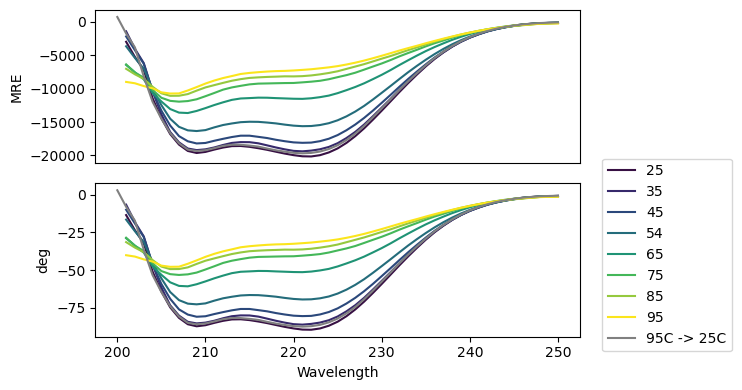

In [ ]:
### Input ###
#CD_result_path = "/net/expdata/Users/Baker_Lab/woodbuse/cd_J1500/zinc_hydrolase_manuscript_2025/"
CD_result_path = "/home/donghyo/WETLAB_BACKUP/cd_J1500/zinc_hydrolase_manuscript_2025/"
file_name = "thermal_melts/A1_25mMtris_25mMnacl_ph8_noAddedZn__25C_to_95C_1nmBand_Spectrum.csv"
file_name2 = "A1_25mMtris_25mMnacl_ph8_25C___recoveryAFTER95C-x-1.csv"

pathlength = 1 # Unit: mm
protein_concentration = 27.5 * 1e-6
protein_length = 162

### Output ###
save_eps_path = os.path.join("./pics/", "250326_CD_temp_interval_A1_25mMtris_25mMnacl_ph8_noAddedZn.eps")

## Parameter ###
wavelength_min = 200
window_size = 5
colors = ["#371043", "#36296b", "#2b487b", "#246c7b", "#1f9375", "#44b759", "#95c93e", "#fbe51c"]

plot_CD_spectrum_temperature_interval_A1(os.path.join(CD_result_path, file_name), os.path.join(CD_result_path, file_name2), protein_concentration, protein_length, pathlength=pathlength, wavelength_min=wavelength_min, window_size=window_size, colors=colors, save=save_eps_path)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


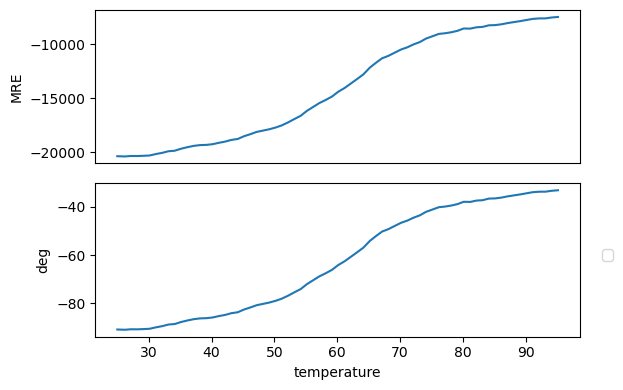

In [ ]:
### Input ###
CD_result_path = "/net/expdata/Users/Baker_Lab/woodbuse/cd_J1500/zinc_hydrolase_manuscript_2025/thermal_melts/"
file_name = "A1_25mMtris_25mMnacl_ph8_noAddedZn__25C_to_95C_1nmBand_222nmMeasurement.csv"

pathlength = 1 # Unit: mm
protein_concentration = 27.5 * 1e-6
protein_length = 162

### Output ###
save_eps_path = os.path.join("./pics/", "250326_CD_temp_interval_222nm_A1_25mMtris_25mMnacl_ph8_noAddedZn.eps")

## Parameter ###
plot_CD_222nm_temperature_interval(os.path.join(CD_result_path, file_name), protein_concentration, protein_length, window_size=3, pathlength=pathlength, save=save_eps_path)

### V.I.B. 250328 A8 ([Enz]: 19.3 uM, 25uM Tris, 25uM NaCl, Temp: 25C)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


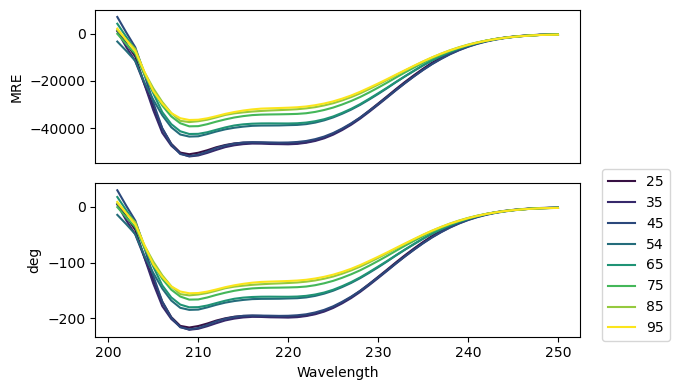

In [ ]:
### Input ###
CD_result_path = "/net/expdata/Users/Baker_Lab/woodbuse/cd_J1500/zinc_hydrolase_manuscript_2025/thermal_melts/"
file_name = "A8_25mMtris_25mMnacl_ph8_noAddedZn__25C_to_95C_1nmBand_Spectrum.csv"

pathlength = 1 # Unit: mm
protein_concentration = 19.3 * 1e-6
protein_length = 220

### Output ###
save_eps_path = os.path.join("./pics/", "250328_CD_temp_interval_A8_25mMtris_25mMnacl_ph8_noAddedZn.eps")

## Parameter ###
wavelength_min = 200
window_size = 5
colors = ["#371043", "#36296b", "#2b487b", "#246c7b", "#1f9375", "#44b759", "#95c93e", "#fbe51c"]

plot_CD_spectrum_temperature_interval(os.path.join(CD_result_path, file_name), protein_concentration, protein_length, pathlength=pathlength, wavelength_min=wavelength_min, window_size=window_size, colors=colors, save=save_eps_path)

### V.I.C. 250328 B9 ([Enz]: 22.4 uM, 25uM Tris, 25uM NaCl, Temp: 25C)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


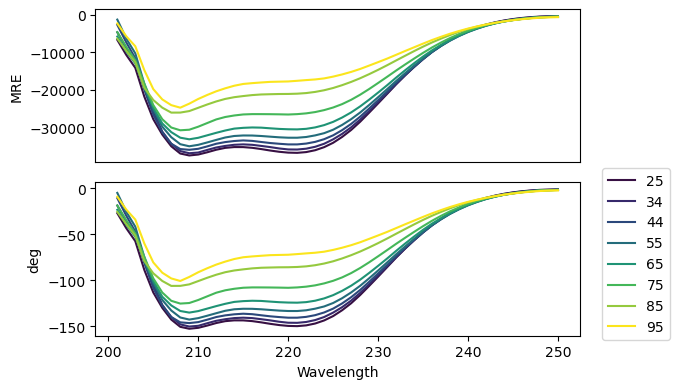

In [ ]:
### Input ###
CD_result_path = "/net/expdata/Users/Baker_Lab/woodbuse/cd_J1500/zinc_hydrolase_manuscript_2025/thermal_melts/"
file_name = "B9_25mMtris_25mMnacl_ph8_noAddedZn__25C_to_95C_1nmBand_Spectrum.csv"

pathlength = 1 # Unit: mm
protein_concentration = 22.4 * 1e-6
protein_length = 182

### Output ###
save_eps_path = os.path.join("./pics/", "250328_CD_temp_interval_B9_25mMtris_25mMnacl_ph8_noAddedZn.eps")

## Parameter ###
wavelength_min = 200
window_size = 5
colors = ["#371043", "#36296b", "#2b487b", "#246c7b", "#1f9375", "#44b759", "#95c93e", "#fbe51c"]

plot_CD_spectrum_temperature_interval(os.path.join(CD_result_path, file_name), protein_concentration, protein_length, pathlength=pathlength, wavelength_min=wavelength_min, window_size=window_size, colors=colors, save=save_eps_path)

### V.I.D. 250328 C4 ([Enz]: 25.7 uM, 25uM Tris, 25uM NaCl, Temp: 25C)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


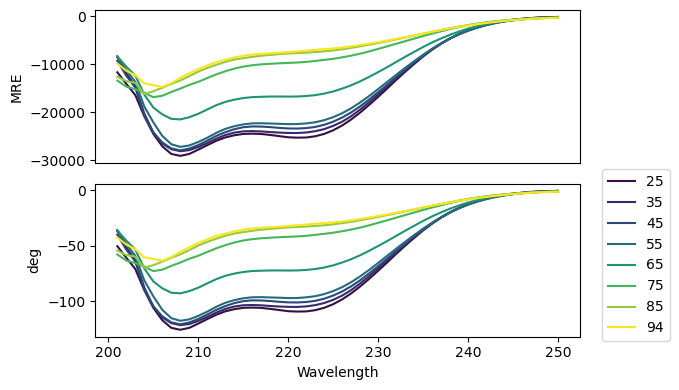

In [ ]:
### Input ###
CD_result_path = "/net/expdata/Users/Baker_Lab/woodbuse/cd_J1500/zinc_hydrolase_manuscript_2025/thermal_melts/"
file_name = "C4pa_25mMtris_25mMnacl_ph8_noAddedZn__25C_to_95C_1nmBand_Spectrum.csv"

pathlength = 1 # Unit: mm
protein_concentration = 25.7 * 1e-6
protein_length = 168

### Output ###
save_eps_path = os.path.join("./pics/", "250328_CD_temp_interval_C4_25mMtris_25mMnacl_ph8_noAddedZn.eps")

## Parameter ###
wavelength_min = 200
window_size = 5
colors = ["#371043", "#36296b", "#2b487b", "#246c7b", "#1f9375", "#44b759", "#95c93e", "#fbe51c"]

plot_CD_spectrum_temperature_interval(os.path.join(CD_result_path, file_name), protein_concentration, protein_length, pathlength=pathlength, wavelength_min=wavelength_min, window_size=window_size, colors=colors, save=save_eps_path)

### V.I.E. 250328 F7 ([Enz]: 28.1 uM, 25uM Tris, 25uM NaCl, Temp: 25C)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


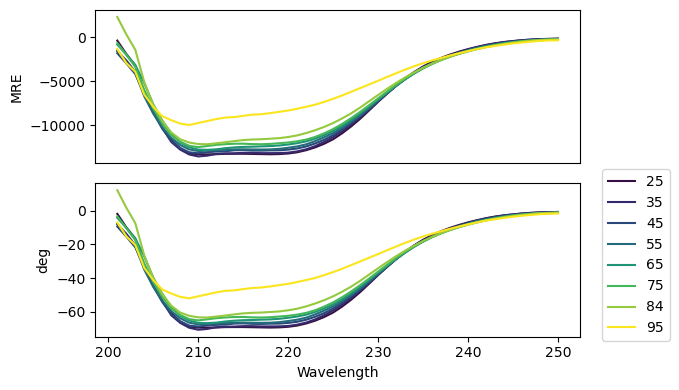

In [ ]:
### Input ###
CD_result_path = "/net/expdata/Users/Baker_Lab/woodbuse/cd_J1500/zinc_hydrolase_manuscript_2025/thermal_melts/"
file_name = "F7_25mMtris_25mMnacl_ph8_noAddedZn__25C_to_95C_1nmBand_Spectrum.csv"

pathlength = 1 # Unit: mm
protein_concentration = 28.1 * 1e-6
protein_length = 185

### Output ###
save_eps_path = os.path.join("./pics/", "250328_CD_temp_interval_F7_25mMtris_25mMnacl_ph8_noAddedZn.eps")

## Parameter ###
wavelength_min = 200
window_size = 5
colors = ["#371043", "#36296b", "#2b487b", "#246c7b", "#1f9375", "#44b759", "#95c93e", "#fbe51c"]

plot_CD_spectrum_temperature_interval(os.path.join(CD_result_path, file_name), protein_concentration, protein_length, pathlength=pathlength, wavelength_min=wavelength_min, window_size=window_size, colors=colors, save=save_eps_path)

### V.I.F. 250328 H10 ([Enz]: 33.1 uM, 25uM Tris, 25uM NaCl, Temp: 25C)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


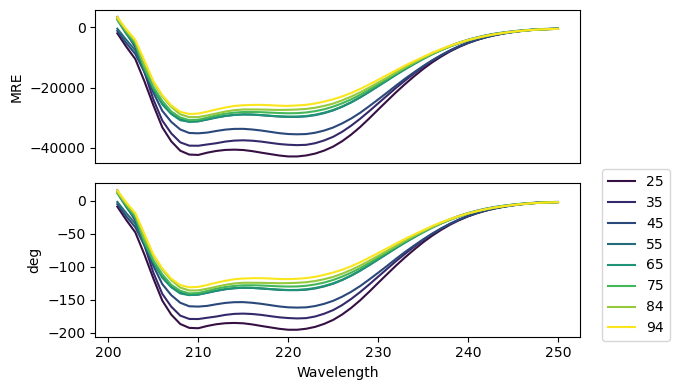

In [ ]:
### Input ###
CD_result_path = "/net/expdata/Users/Baker_Lab/woodbuse/cd_J1500/zinc_hydrolase_manuscript_2025/thermal_melts/"
file_name = "H10_25mMtris_25mMnacl_ph8_noAddedZn__25C_to_95C_1nmBand_Spectrum.csv"

pathlength = 1 # Unit: mm
protein_concentration = 33.1 * 1e-6
protein_length = 138

### Output ###
save_eps_path = os.path.join("./pics/", "250328_CD_temp_interval_H10_25mMtris_25mMnacl_ph8_noAddedZn.eps")

## Parameter ###cc
wavelength_min = 200
window_size = 5
colors = ["#371043", "#36296b", "#2b487b", "#246c7b", "#1f9375", "#44b759", "#95c93e", "#fbe51c"]

plot_CD_spectrum_temperature_interval(os.path.join(CD_result_path, file_name), protein_concentration, protein_length, pathlength=pathlength, wavelength_min=wavelength_min, window_size=window_size, colors=colors, save=save_eps_path)

### V.I.G. 250328 H6 ([Enz]: 39.4 uM, 25uM Tris, 25uM NaCl, Temp: 25C)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


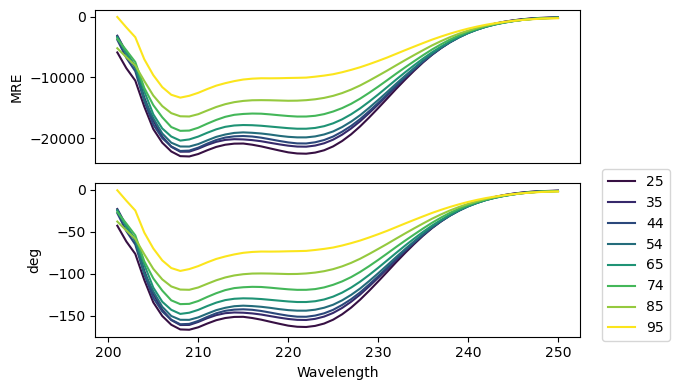

In [ ]:
### Input ###
CD_result_path = "/net/expdata/Users/Baker_Lab/woodbuse/cd_J1500/zinc_hydrolase_manuscript_2025/thermal_melts/"
file_name = "H6_25mMtris_25mMnacl_ph8_noAddedZn__25C_to_95C_1nmBand_Spectrum.csv"

pathlength = 1 # Unit: mm
protein_concentration = 39.4 * 1e-6
protein_length = 184

### Output ###
save_eps_path = os.path.join("./pics/", "250328_CD_temp_interval_H6_25mMtris_25mMnacl_ph8_noAddedZn.eps")

## Parameter ###
wavelength_min = 200
window_size = 5
colors = ["#371043", "#36296b", "#2b487b", "#246c7b", "#1f9375", "#44b759", "#95c93e", "#fbe51c"]

plot_CD_spectrum_temperature_interval(os.path.join(CD_result_path, file_name), protein_concentration, protein_length, pathlength=pathlength, wavelength_min=wavelength_min, window_size=window_size, colors=colors, save=save_eps_path)

### V.I.H. 250416 C5 ([Enz]: 16.5 uM, 25uM Tris, 25uM NaCl, Temp: 25C)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


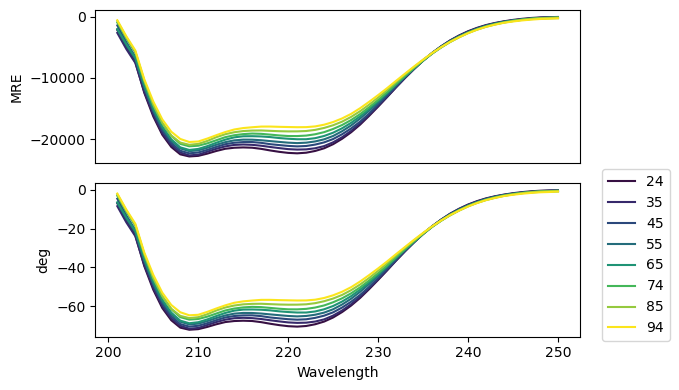

In [ ]:
### Input ###
CD_result_path = "/net/expdata/Users/Baker_Lab/woodbuse/cd_J1500/zinc_hydrolase_manuscript_2025/thermal_melts/"
file_name = "C5_25mMtris_25mMnacl_ph8_noAddedZn__25C_to_95C_1nmBand_Spectrum.csv"

pathlength = 1 # Unit: mm
protein_concentration = 16.5 * 1e-6
protein_length = 192

### Output ###
save_eps_path = os.path.join("./pics/", "250416_CD_temp_interval_C5_25mMtris_25mMnacl_ph8_noAddedZn.eps")

## Parameter ###
wavelength_min = 200
window_size = 5
colors = ["#371043", "#36296b", "#2b487b", "#246c7b", "#1f9375", "#44b759", "#95c93e", "#fbe51c"]

plot_CD_spectrum_temperature_interval(os.path.join(CD_result_path, file_name), protein_concentration, protein_length, pathlength=pathlength, wavelength_min=wavelength_min, window_size=window_size, colors=colors, save=save_eps_path)